In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
np.random.seed(5)

In [307]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy(n=11):
    inputs = []
    labels = []
    step = 1/(n-1)
    for i in range(n):
        inputs.append([step*i, step*i])
        labels.append(0)
        
        if i == int((n-1)/2):
            continue
        
        inputs.append([step*i, 1 - step*i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(n*2 - 1,1)
def show_data(xs, ys, ts):
    cm = LinearSegmentedColormap.from_list(
        'mymap', [(1, 0, 0), (0, 0, 1)], N=2)
    n = len(xs)
    plt.figure(figsize=(5*n, 5))
    for i, x, y, t in zip(range(n), xs, ys, ts):
        y = np.round(y)
        plt.subplot(1,n, i+1)
        plt.title(t, fontsize=18)
        plt.scatter(x[:,0], x[:,1], c=y[:,0], cmap=cm)
    
    plt.show()
def show_result(x, y, pred_y):
    x = np.array(x)
    y = np.array(y)
    plt.subplot(1,2,1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')

    plt.subplot(1,2,2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0],x[i][1],'ro')
        else:
            plt.plot(x[i][0],x[i][1],'bo')
    plt.show()
    
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

#def derivative_sigmoid(x):
#    return np.multiply(sigmoid(x), 1.0 - sigmoid(x))

def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)

def relu(X):
    X = np.copy(X)
    for i in range(X.shape[1]):
        X[0][i] = max(0.0, X[0][i])
    return X

def derivative_relu(X):
    d_X = np.copy(X)
    for i in range(d_X.shape[1]):
        if(d_X[0][i]>0.0):
            d_X[0][i] = 1.0
        else:
            d_X[0][i] = 0.0
    return d_X

def lrelu(X,a=0.01):
    X = np.copy(X)
    for i in range(X.shape[1]):
        if(X[0][i]<0.0):
            X[0][i] *= a

    return X

def derivative_lrelu(X,a=0.01):
    d_X = np.copy(X)
    for i in range(d_X.shape[1]):
        if(d_X[0][i]>0.0):
            d_X[0][i] = 1.0
        else:
            d_X[0][i] = a
    return d_X

def MSE_loss(y, y_hat):
    return np.mean((y - y_hat)**2)

def derivative_MSE_loss(y, y_hat):
    return (y - y_hat)*(2/y.shape[0])

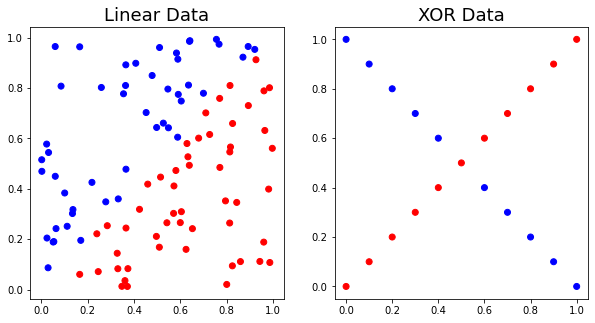

In [308]:
x1, y1 = generate_linear()
x2, y2 = generate_XOR_easy()
show_data([x1,x2], [y1,y2], ['Linear Data', 'XOR Data'])

In [309]:
class linear:
    def __init__(self,in_size,out_size,act):
        self.prev_X = np.zeros((1,in_size))
        self.prev_Y = np.zeros((1,out_size))
        self.prev_sig = np.zeros((1,out_size))
        self.W = np.random.uniform(0,1,(in_size,out_size))
        self.W_grad = np.zeros((in_size,out_size))
        self.backward_gradient = np.zeros(out_size)
        self.act = act

        

    #calculate the value W*X, and store X for gradient calculation
    def forward(self,X):
        #self.prev_X = X
        self.prev_X = np.copy(X)
        self.prev_Y = np.matmul(X,self.W)

        if(self.act == 'sigmoid'):
            self.prev_sig = sigmoid(self.prev_Y)
            return np.copy(self.prev_sig)
        elif(self.act == 'relu'):
            return relu(self.prev_Y)
        elif(self.act == 'lrelu'):
            return lrelu(self.prev_Y)
        elif(self.act == 'no'):
            return np.copy(self.prev_Y)


    def backword(self,derivative):

        if(self.act == 'sigmoid'):
       
            self.backward_gradient=np.copy(derivative_sigmoid(self.prev_sig))
            for i in range(derivative.shape[1]):
                self.backward_gradient[0][i] *= derivative[0][i]
        elif(self.act == 'relu'):
            self.backward_gradient=np.copy(derivative_relu(self.prev_Y))
            for i in range(derivative.shape[1]):
                self.backward_gradient[0][i] *= derivative[0][i]
            
        elif(self.act == 'lrelu'):
            self.backward_gradient=np.copy(derivative_lrelu(self.prev_Y))
            for i in range(derivative.shape[1]):
                self.backward_gradient[0][i] *= derivative[0][i]
            
        elif(self.act == 'no'):
            self.backward_gradient = np.copy(derivative)

        return np.matmul(self.backward_gradient,self.W.T)

    def get_weights(self,learning_rate):
        for i in range(self.prev_X.shape[1]):
            for j in range(self.prev_Y.shape[1]):
                self.W_grad[i][j] -= learning_rate*self.prev_X[0][i]*self.backward_gradient[0][j]

        #self.W_grad[:] = 0
    def update_weights(self,batch_size):

        self.W += self.W_grad/batch_size
        self.W_grad[:] = 0

        
    
    def debug(self):
        return self.W
        
        

In [352]:
class My_NN:
    def __init__(self,learning_rate = 0.01):
        self.layers = []
        self.learning_rate = learning_rate
    def forward(self,X):
        in_data = X
        for l in self.layers:
            in_data = l.forward(in_data)
        return in_data
    def backword(self,derivative):
        back_dev = derivative
        for l in reversed(self.layers):
            
            back_dev = l.backword(back_dev)
            l.get_weights(self.learning_rate)
        #return back_dev
        
    def add_linear_layer(self,in_size,out_size,act):
        l = linear(in_size,out_size,act)
        self.layers.append(l)
        
    def update_weights(self,batch_size):
        for l in self.layers:
            l.update_weights(batch_size)
            
    def show_weights(self):
        for l in self.layers:
            print(l.debug())
    

In [381]:
np.random.seed(5)
n = My_NN()


In [382]:
#n.add_linear_layer(in_size = 2, out_size = 10,act = 'sigmoid')
n.add_linear_layer(in_size = 2, out_size = 10, act = 'lrelu')
n.add_linear_layer(in_size = 10,out_size = 1, act = 'sigmoid')

In [ ]:
test_x = x2[:]
test_y = y2[:]
for i in range(100000):
    print(f"epoch {i}")
    loss = 0
    for data,label in zip(test_x,test_y):
        ret = n.forward(np.array(data).reshape(1,2))       
        loss += MSE_loss(ret,label)    
        n.backword(derivative_MSE_loss(ret,label))
    
    print(f"MSE loss = {loss/len(test_x)}")
    n.update_weights(len(test_x))
    print("             ")
    
    #n.show_weights()
    
    

epoch 0
MSE loss = 0.3648278688010268
             
epoch 1
MSE loss = 0.36471071658499055
             
epoch 2
MSE loss = 0.3645933567198319
             
epoch 3
MSE loss = 0.3644757888245984
             
epoch 4
MSE loss = 0.3643580125185115
             
epoch 5
MSE loss = 0.3642400274209792
             
epoch 6
MSE loss = 0.3641218331516086
             
epoch 7
MSE loss = 0.36400342933021895
             
epoch 8
MSE loss = 0.36388481557685487
             
epoch 9
MSE loss = 0.36376599151179967
             
epoch 10
MSE loss = 0.3636469567555888
             
epoch 11
MSE loss = 0.3635277109290236
             
epoch 12
MSE loss = 0.36340825365318474
             
epoch 13
MSE loss = 0.36328858454944685
             
epoch 14
MSE loss = 0.36316870323949224
             
epoch 15
MSE loss = 0.36304860934532485
             
epoch 16
MSE loss = 0.36292830248928576
             
epoch 17
MSE loss = 0.36280778229406685
             
epoch 18
MSE loss = 0.36268704838272636
      

MSE loss = 0.33566765891465244
             
epoch 208
MSE loss = 0.3355012648801513
             
epoch 209
MSE loss = 0.3353346240826428
             
epoch 210
MSE loss = 0.3351677368241211
             
epoch 211
MSE loss = 0.33500060341564114
             
epoch 212
MSE loss = 0.33483322417740324
             
epoch 213
MSE loss = 0.3346655994388386
             
epoch 214
MSE loss = 0.33449772953869583
             
epoch 215
MSE loss = 0.33432961482512685
             
epoch 216
MSE loss = 0.3341612556557746
             
epoch 217
MSE loss = 0.33399265239785886
             
epoch 218
MSE loss = 0.33382380542826495
             
epoch 219
MSE loss = 0.3336547151336311
             
epoch 220
MSE loss = 0.3334853819104367
             
epoch 221
MSE loss = 0.3333158061650905
             
epoch 222
MSE loss = 0.33314598831402004
             
epoch 223
MSE loss = 0.3329759287837605
             
epoch 224
MSE loss = 0.3328056280110442
             
epoch 225
MSE loss = 0.3326350

MSE loss = 0.29482629475106054
             
epoch 428
MSE loss = 0.2946347850921002
             
epoch 429
MSE loss = 0.2944434325196933
             
epoch 430
MSE loss = 0.2942522405627869
             
epoch 431
MSE loss = 0.2940612127562242
             
epoch 432
MSE loss = 0.29387035264043265
             
epoch 433
MSE loss = 0.2936796637611087
             
epoch 434
MSE loss = 0.29348914966889966
             
epoch 435
MSE loss = 0.2932988139190818
             
epoch 436
MSE loss = 0.29310866007123626
             
epoch 437
MSE loss = 0.2929186916889212
             
epoch 438
MSE loss = 0.2927289123393412
             
epoch 439
MSE loss = 0.29253932559301365
             
epoch 440
MSE loss = 0.2923499350234329
             
epoch 441
MSE loss = 0.29216074420673044
             
epoch 442
MSE loss = 0.29197175672133335
             
epoch 443
MSE loss = 0.2917829761476195
             
epoch 444
MSE loss = 0.2915944060675703
             
epoch 445
MSE loss = 0.29140605

MSE loss = 0.2621057002925502
             
epoch 635
MSE loss = 0.2619940890281204
             
epoch 636
MSE loss = 0.26188302910604533
             
epoch 637
MSE loss = 0.261772519752322
             
epoch 638
MSE loss = 0.261662560166546
             
epoch 639
MSE loss = 0.2615531495221739
             
epoch 640
MSE loss = 0.2614442869667891
             
epoch 641
MSE loss = 0.26133597162236905
             
epoch 642
MSE loss = 0.2612282025855542
             
epoch 643
MSE loss = 0.2611209789279202
             
epoch 644
MSE loss = 0.26101429969625023
             
epoch 645
MSE loss = 0.26090816391281163
             
epoch 646
MSE loss = 0.2608025705756316
             
epoch 647
MSE loss = 0.26069751865877644
             
epoch 648
MSE loss = 0.26059300711263134
             
epoch 649
MSE loss = 0.2604890348641826
             
epoch 650
MSE loss = 0.26038560081730033
             
epoch 651
MSE loss = 0.2602827038530231
             
epoch 652
MSE loss = 0.2601803428

MSE loss = 0.2504726195954743
             
epoch 836
MSE loss = 0.2504417538927967
             
epoch 837
MSE loss = 0.2504186823545374
             
epoch 838
MSE loss = 0.2503931153873924
             
epoch 839
MSE loss = 0.25036438846269893
             
epoch 840
MSE loss = 0.2503451764261239
             
epoch 841
MSE loss = 0.25031517113909674
             
epoch 842
MSE loss = 0.25029359319912614
             
epoch 843
MSE loss = 0.25026824541652504
             
epoch 844
MSE loss = 0.25024113185342167
             
epoch 845
MSE loss = 0.2502219946938974
             
epoch 846
MSE loss = 0.2501928196200921
             
epoch 847
MSE loss = 0.25017297752695283
             
epoch 848
MSE loss = 0.2501475461763314
             
epoch 849
MSE loss = 0.25012228587964885
             
epoch 850
MSE loss = 0.25010292385565824
             
epoch 851
MSE loss = 0.2500745496072585
             
epoch 852
MSE loss = 0.2500566805342084
             
epoch 853
MSE loss = 0.2500308

MSE loss = 0.24759381563120864
             
epoch 1042
MSE loss = 0.24758833933070198
             
epoch 1043
MSE loss = 0.2475811839217757
             
epoch 1044
MSE loss = 0.24757350153719493
             
epoch 1045
MSE loss = 0.24756868650454106
             
epoch 1046
MSE loss = 0.2475588207960576
             
epoch 1047
MSE loss = 0.24755632101801175
             
epoch 1048
MSE loss = 0.24754429453066104
             
epoch 1049
MSE loss = 0.24754408513905243
             
epoch 1050
MSE loss = 0.24753160963119505
             
epoch 1051
MSE loss = 0.24753028246620323
             
epoch 1052
MSE loss = 0.2475195572611295
             
epoch 1053
MSE loss = 0.24751611656494227
             
epoch 1054
MSE loss = 0.24750762900601603
             
epoch 1055
MSE loss = 0.24750209665541018
             
epoch 1056
MSE loss = 0.24749582266976086
             
epoch 1057
MSE loss = 0.24748822033459802
             
epoch 1058
MSE loss = 0.2474841360921664
             
epoch 1

MSE loss = 0.24664743134025965
             
epoch 1245
MSE loss = 0.24664985885599278
             
epoch 1246
MSE loss = 0.24664022292907362
             
epoch 1247
MSE loss = 0.24664343080644138
             
epoch 1248
MSE loss = 0.24663370912898383
             
epoch 1249
MSE loss = 0.24663635360973554
             
epoch 1250
MSE loss = 0.2466273069120859
             
epoch 1251
MSE loss = 0.24662920833729368
             
epoch 1252
MSE loss = 0.24662092298607302
             
epoch 1253
MSE loss = 0.24662209020390835
             
epoch 1254
MSE loss = 0.24661455694652318
             
epoch 1255
MSE loss = 0.2466149987206996
             
epoch 1256
MSE loss = 0.24660820839619824
             
epoch 1257
MSE loss = 0.2466079334067528
             
epoch 1258
MSE loss = 0.24660187694492047
             
epoch 1259
MSE loss = 0.246600893788987
             
epoch 1260
MSE loss = 0.246595562209451
             
epoch 1261
MSE loss = 0.24659387940202634
             
epoch 1262

MSE loss = 0.2459877716237487
             
epoch 1461
MSE loss = 0.2459820541772131
             
epoch 1462
MSE loss = 0.24598182925468323
             
epoch 1463
MSE loss = 0.24597627325644286
             
epoch 1464
MSE loss = 0.24597588922478947
             
epoch 1465
MSE loss = 0.2459704914417889
             
epoch 1466
MSE loss = 0.24596995144168762
             
epoch 1467
MSE loss = 0.24596470867509831
             
epoch 1468
MSE loss = 0.24596401581437974
             
epoch 1469
MSE loss = 0.24595892489929183
             
epoch 1470
MSE loss = 0.24595808225322682
             
epoch 1471
MSE loss = 0.2459531400583439
             
epoch 1472
MSE loss = 0.24595215066992596
             
epoch 1473
MSE loss = 0.24594735409726293
             
epoch 1474
MSE loss = 0.2459462209774889
             
epoch 1475
MSE loss = 0.24594156696207273
             
epoch 1476
MSE loss = 0.24594029309021928
             
epoch 1477
MSE loss = 0.24593577859979313
             
epoch 14

MSE loss = 0.24535212034358655
             
epoch 1675
MSE loss = 0.24535082012491832
             
epoch 1676
MSE loss = 0.24534609200503132
             
epoch 1677
MSE loss = 0.24534475308123221
             
epoch 1678
MSE loss = 0.24534006086655666
             
epoch 1679
MSE loss = 0.24533868238946077
             
epoch 1680
MSE loss = 0.24533402690564585
             
epoch 1681
MSE loss = 0.24533260804071555
             
epoch 1682
MSE loss = 0.24532799010002157
             
epoch 1683
MSE loss = 0.24532653002623775
             
epoch 1684
MSE loss = 0.24532195042764285
             
epoch 1685
MSE loss = 0.2453204483373949
             
epoch 1686
MSE loss = 0.24531590786670057
             
epoch 1687
MSE loss = 0.2453143629656786
             
epoch 1688
MSE loss = 0.24530986239561434
             
epoch 1689
MSE loss = 0.2453082739027016
             
epoch 1690
MSE loss = 0.2453038139930285
             
epoch 1691
MSE loss = 0.24530218114019547
             
epoch 1

MSE loss = 0.24471971281623559
             
epoch 1879
MSE loss = 0.24471204066346375
             
epoch 1880
MSE loss = 0.24471331203839894
             
epoch 1881
MSE loss = 0.2447055695779851
             
epoch 1882
MSE loss = 0.2447069069459919
             
epoch 1883
MSE loss = 0.24469909429291437
             
epoch 1884
MSE loss = 0.24470049752885545
             
epoch 1885
MSE loss = 0.24469261480441323
             
epoch 1886
MSE loss = 0.24469408377688115
             
epoch 1887
MSE loss = 0.24468613110865142
             
epoch 1888
MSE loss = 0.24468766568001032
             
epoch 1889
MSE loss = 0.2446796432018057
             
epoch 1890
MSE loss = 0.24468124322823334
             
epoch 1891
MSE loss = 0.24467315108005994
             
epoch 1892
MSE loss = 0.2446748164115889
             
epoch 1893
MSE loss = 0.24466665473960508
             
epoch 1894
MSE loss = 0.24466838522016351
             
epoch 1895
MSE loss = 0.24466015417663844
             
epoch 1

MSE loss = 0.24403222204289451
             
epoch 2084
MSE loss = 0.2440336152498436
             
epoch 2085
MSE loss = 0.24402533235254106
             
epoch 2086
MSE loss = 0.2440266936591821
             
epoch 2087
MSE loss = 0.2440184374690597
             
epoch 2088
MSE loss = 0.24401976748715998
             
epoch 2089
MSE loss = 0.24401153738510944
             
epoch 2090
MSE loss = 0.24401283672983226
             
epoch 2091
MSE loss = 0.24400463209335999
             
epoch 2092
MSE loss = 0.24400590138325054
             
epoch 2093
MSE loss = 0.243997721586492
             
epoch 2094
MSE loss = 0.24399896144346211
             
epoch 2095
MSE loss = 0.24399080585719654
             
epoch 2096
MSE loss = 0.24399201690651048
             
epoch 2097
MSE loss = 0.24398388489817502
             
epoch 2098
MSE loss = 0.24398506776843534
             
epoch 2099
MSE loss = 0.24397695870213928
             
epoch 2100
MSE loss = 0.24397811402527278
             
epoch 21

MSE loss = 0.24333868996260763
             
epoch 2278
MSE loss = 0.2433402957233376
             
epoch 2279
MSE loss = 0.24333126353639367
             
epoch 2280
MSE loss = 0.2433329108407159
             
epoch 2281
MSE loss = 0.24332383123846008
             
epoch 2282
MSE loss = 0.2433255209779258
             
epoch 2283
MSE loss = 0.24331639306202657
             
epoch 2284
MSE loss = 0.24331812613071668
             
epoch 2285
MSE loss = 0.24330894900031505
             
epoch 2286
MSE loss = 0.24331072629483588
             
epoch 2287
MSE loss = 0.24330149904654969
             
epoch 2288
MSE loss = 0.2433033214660288
             
epoch 2289
MSE loss = 0.24329404319395687
             
epoch 2290
MSE loss = 0.24329591164003875
             
epoch 2291
MSE loss = 0.2432865814357651
             
epoch 2292
MSE loss = 0.24328849681260692
             
epoch 2293
MSE loss = 0.24327911376520517
             
epoch 2294
MSE loss = 0.2432810769794727
             
epoch 229

MSE loss = 0.2425700499109523
             
epoch 2479
MSE loss = 0.24256442917272406
             
epoch 2480
MSE loss = 0.24256200005874767
             
epoch 2481
MSE loss = 0.24255652293518198
             
epoch 2482
MSE loss = 0.24255394366805863
             
epoch 2483
MSE loss = 0.24254861127565505
             
epoch 2484
MSE loss = 0.24254588073210095
             
epoch 2485
MSE loss = 0.2425406941898601
             
epoch 2486
MSE loss = 0.2425378112440903
             
epoch 2487
MSE loss = 0.24253277167351353
             
epoch 2488
MSE loss = 0.24252973519724264
             
epoch 2489
MSE loss = 0.2425248437223311
             
epoch 2490
MSE loss = 0.24252165258477407
             
epoch 2491
MSE loss = 0.24251691033202843
             
epoch 2492
MSE loss = 0.24251356339990093
             
epoch 2493
MSE loss = 0.24250897149832046
             
epoch 2494
MSE loss = 0.24250546763583963
             
epoch 2495
MSE loss = 0.242501027216922
             
epoch 249

MSE loss = 0.24170803048507059
             
epoch 2687
MSE loss = 0.24170096264368088
             
epoch 2688
MSE loss = 0.2416995412714075
             
epoch 2689
MSE loss = 0.24169219305413953
             
epoch 2690
MSE loss = 0.2416910461836314
             
epoch 2691
MSE loss = 0.2416834162261084
             
epoch 2692
MSE loss = 0.2416825452175941
             
epoch 2693
MSE loss = 0.2416746321526619
             
epoch 2694
MSE loss = 0.24167403836914814
             
epoch 2695
MSE loss = 0.2416658408268739
             
epoch 2696
MSE loss = 0.2416655256341467
             
epoch 2697
MSE loss = 0.24165704224181792
             
epoch 2698
MSE loss = 0.24165700700844386
             
epoch 2699
MSE loss = 0.2416482363905675
             
epoch 2700
MSE loss = 0.24164848248789422
             
epoch 2701
MSE loss = 0.2416394232661958
             
epoch 2702
MSE loss = 0.24163995206835312
             
epoch 2703
MSE loss = 0.24163060286177582
             
epoch 2704
M

MSE loss = 0.24078402088731293
             
epoch 2893
MSE loss = 0.24077696904178073
             
epoch 2894
MSE loss = 0.2407749071879573
             
epoch 2895
MSE loss = 0.24076741793746634
             
epoch 2896
MSE loss = 0.2407657871730287
             
epoch 2897
MSE loss = 0.2407578589014438
             
epoch 2898
MSE loss = 0.2407566608387246
             
epoch 2899
MSE loss = 0.24074829192653074
             
epoch 2900
MSE loss = 0.2407475281812434
             
epoch 2901
MSE loss = 0.24073871700554544
             
epoch 2902
MSE loss = 0.24073838919678442
             
epoch 2903
MSE loss = 0.24072913413130725
             
epoch 2904
MSE loss = 0.24072924388154776
             
epoch 2905
MSE loss = 0.24071954329663625
             
epoch 2906
MSE loss = 0.2407200922317348
             
epoch 2907
MSE loss = 0.2407099444943535
             
epoch 2908
MSE loss = 0.24071093424354745
             
epoch 2909
MSE loss = 0.2407003377172807
             
epoch 2910


MSE loss = 0.23978760596441942
             
epoch 3098
MSE loss = 0.2397852305767416
             
epoch 3099
MSE loss = 0.2397778297783622
             
epoch 3100
MSE loss = 0.23977482932966904
             
epoch 3101
MSE loss = 0.239768046857766
             
epoch 3102
MSE loss = 0.23976441945915927
             
epoch 3103
MSE loss = 0.2397582571993745
             
epoch 3104
MSE loss = 0.23975400095769572
             
epoch 3105
MSE loss = 0.2397484607999319
             
epoch 3106
MSE loss = 0.23974357381776476
             
epoch 3107
MSE loss = 0.23973865765618269
             
epoch 3108
MSE loss = 0.23973313803185659
             
epoch 3109
MSE loss = 0.23972884776487197
             
epoch 3110
MSE loss = 0.23972269359246448
             
epoch 3111
MSE loss = 0.23971903112274504
             
epoch 3112
MSE loss = 0.23971224049208525
             
epoch 3113
MSE loss = 0.23970920772654802
             
epoch 3114
MSE loss = 0.23970177872321866
             
epoch 311

MSE loss = 0.23873007798572093
             
epoch 3301
MSE loss = 0.23871595534634896
             
epoch 3302
MSE loss = 0.2387196070716248
             
epoch 3303
MSE loss = 0.23870464080041046
             
epoch 3304
MSE loss = 0.23870912905940708
             
epoch 3305
MSE loss = 0.23869333765279657
             
epoch 3306
MSE loss = 0.23869862527496205
             
epoch 3307
MSE loss = 0.23868285185285976
             
epoch 3308
MSE loss = 0.23868728621861557
             
epoch 3309
MSE loss = 0.23867235892568617
             
epoch 3310
MSE loss = 0.2386759378410403
             
epoch 3311
MSE loss = 0.23866185886878422
             
epoch 3312
MSE loss = 0.23866458013431077
             
epoch 3313
MSE loss = 0.23865135167966128
             
epoch 3314
MSE loss = 0.23865321309050877
             
epoch 3315
MSE loss = 0.23864083735582461
             
epoch 3316
MSE loss = 0.23864183670172393
             
epoch 3317
MSE loss = 0.23863031589477984
             
epoch

MSE loss = 0.23757696298890454
             
epoch 3504
MSE loss = 0.23757522568473197
             
epoch 3505
MSE loss = 0.2375657695160371
             
epoch 3506
MSE loss = 0.23756292403295895
             
epoch 3507
MSE loss = 0.2375545686020827
             
epoch 3508
MSE loss = 0.23755061238546496
             
epoch 3509
MSE loss = 0.23754336024532482
             
epoch 3510
MSE loss = 0.23753829073408794
             
epoch 3511
MSE loss = 0.2375321444440456
             
epoch 3512
MSE loss = 0.237525959070677
             
epoch 3513
MSE loss = 0.2375209211965259
             
epoch 3514
MSE loss = 0.23751361738709226
             
epoch 3515
MSE loss = 0.23750969050104492
             
epoch 3516
MSE loss = 0.23750126567520502
             
epoch 3517
MSE loss = 0.23749845235588113
             
epoch 3518
MSE loss = 0.23748890392689775
             
epoch 3519
MSE loss = 0.2374872067593115
             
epoch 3520
MSE loss = 0.23747653213406328
             
epoch 3521

MSE loss = 0.2363097409692512
             
epoch 3713
MSE loss = 0.2362948129467467
             
epoch 3714
MSE loss = 0.23629777474752822
             
epoch 3715
MSE loss = 0.23628142093994484
             
epoch 3716
MSE loss = 0.23628580081805767
             
epoch 3717
MSE loss = 0.2362680182372246
             
epoch 3718
MSE loss = 0.236273819180092
             
epoch 3719
MSE loss = 0.2362558920909677
             
epoch 3720
MSE loss = 0.2362605452338086
             
epoch 3721
MSE loss = 0.23624390323464262
             
epoch 3722
MSE loss = 0.23624711347609054
             
epoch 3723
MSE loss = 0.23623190663818375
             
epoch 3724
MSE loss = 0.23623367102958556
             
epoch 3725
MSE loss = 0.23621990230108741
             
epoch 3726
MSE loss = 0.23622021788564776
             
epoch 3727
MSE loss = 0.23620789022284625
             
epoch 3728
MSE loss = 0.23620675403564972
             
epoch 3729
MSE loss = 0.23619587040294943
             
epoch 3730

MSE loss = 0.23499975979961127
             
epoch 3913
MSE loss = 0.23498374331696537
             
epoch 3914
MSE loss = 0.23498525567233963
             
epoch 3915
MSE loss = 0.2349710241827174
             
epoch 3916
MSE loss = 0.23497074026529352
             
epoch 3917
MSE loss = 0.2349582971125791
             
epoch 3918
MSE loss = 0.23495621356943802
             
epoch 3919
MSE loss = 0.23494556210726875
             
epoch 3920
MSE loss = 0.2349416755757658
             
epoch 3921
MSE loss = 0.2349328191674987
             
epoch 3922
MSE loss = 0.23492712627529647
             
epoch 3923
MSE loss = 0.2349200682939751
             
epoch 3924
MSE loss = 0.2349125656590769
             
epoch 3925
MSE loss = 0.23490730948739855
             
epoch 3926
MSE loss = 0.23489799371818035
             
epoch 3927
MSE loss = 0.23489454274846344
             
epoch 3928
MSE loss = 0.23488341044370661
             
epoch 3929
MSE loss = 0.23488176807785877
             
epoch 393

MSE loss = 0.23358205367430881
             
epoch 4114
MSE loss = 0.23357602661435925
             
epoch 4115
MSE loss = 0.23356636083738078
             
epoch 4116
MSE loss = 0.2335625446759305
             
epoch 4117
MSE loss = 0.23355065613843656
             
epoch 4118
MSE loss = 0.23354905467913445
             
epoch 4119
MSE loss = 0.23353493956812002
             
epoch 4120
MSE loss = 0.2335355566261069
             
epoch 4121
MSE loss = 0.23351921111711263
             
epoch 4122
MSE loss = 0.2335220505189745
             
epoch 4123
MSE loss = 0.23350347077613248
             
epoch 4124
MSE loss = 0.23350853635985497
             
epoch 4125
MSE loss = 0.23348830335905385
             
epoch 4126
MSE loss = 0.23349443276429374
             
epoch 4127
MSE loss = 0.2334747836177717
             
epoch 4128
MSE loss = 0.2334786585747594
             
epoch 4129
MSE loss = 0.23346125578962734
             
epoch 4130
MSE loss = 0.23346287251530992
             
epoch 41

MSE loss = 0.23204496664851804
             
epoch 4319
MSE loss = 0.23203031636169139
             
epoch 4320
MSE loss = 0.2320279901183571
             
epoch 4321
MSE loss = 0.2320160683578097
             
epoch 4322
MSE loss = 0.23201100124868218
             
epoch 4323
MSE loss = 0.23200181221956062
             
epoch 4324
MSE loss = 0.23199400002925255
             
epoch 4325
MSE loss = 0.23198754795102733
             
epoch 4326
MSE loss = 0.2319769864498841
             
epoch 4327
MSE loss = 0.23197327555627806
             
epoch 4328
MSE loss = 0.23195996050044737
             
epoch 4329
MSE loss = 0.2319589950393663
             
epoch 4330
MSE loss = 0.23194292217086826
             
epoch 4331
MSE loss = 0.23194470640433096
             
epoch 4332
MSE loss = 0.23192587145112692
             
epoch 4333
MSE loss = 0.2319304096551965
             
epoch 4334
MSE loss = 0.2319089286953754
             
epoch 4335
MSE loss = 0.23191598834547347
             
epoch 433

MSE loss = 0.23037681230567075
             
epoch 4526
MSE loss = 0.23037220982587217
             
epoch 4527
MSE loss = 0.23036181401517858
             
epoch 4528
MSE loss = 0.230353866002109
             
epoch 4529
MSE loss = 0.23034680760428886
             
epoch 4530
MSE loss = 0.23033550944077355
             
epoch 4531
MSE loss = 0.2303317930792416
             
epoch 4532
MSE loss = 0.23031714013070334
             
epoch 4533
MSE loss = 0.2303167704462548
             
epoch 4534
MSE loss = 0.23029875806081399
             
epoch 4535
MSE loss = 0.23030173971152462
             
epoch 4536
MSE loss = 0.23028036322009876
             
epoch 4537
MSE loss = 0.23028670088122588
             
epoch 4538
MSE loss = 0.2302639763859893
             
epoch 4539
MSE loss = 0.2302696376074182
             
epoch 4540
MSE loss = 0.23024893499884408
             
epoch 4541
MSE loss = 0.2302512038109526
             
epoch 4542
MSE loss = 0.2302338854762611
             
epoch 4543


MSE loss = 0.22856183377886213
             
epoch 4739
MSE loss = 0.22854452224018842
             
epoch 4740
MSE loss = 0.22854202942187576
             
epoch 4741
MSE loss = 0.2285287856610974
             
epoch 4742
MSE loss = 0.2285222121035686
             
epoch 4743
MSE loss = 0.22851304104171258
             
epoch 4744
MSE loss = 0.22850238181101296
             
epoch 4745
MSE loss = 0.22849728839093758
             
epoch 4746
MSE loss = 0.22848253853139594
             
epoch 4747
MSE loss = 0.22848152771764513
             
epoch 4748
MSE loss = 0.22846268225201727
             
epoch 4749
MSE loss = 0.2284657590306758
             
epoch 4750
MSE loss = 0.22844281296028868
             
epoch 4751
MSE loss = 0.2284499823388392
             
epoch 4752
MSE loss = 0.22842594058528295
             
epoch 4753
MSE loss = 0.22843119274717985
             
epoch 4754
MSE loss = 0.2284101634938947
             
epoch 4755
MSE loss = 0.2284112818220359
             
epoch 475

MSE loss = 0.226632773199699
             
epoch 4951
MSE loss = 0.2266178618675036
             
epoch 4952
MSE loss = 0.2266163606674895
             
epoch 4953
MSE loss = 0.22659653755364073
             
epoch 4954
MSE loss = 0.22659994026051283
             
epoch 4955
MSE loss = 0.2265752001852188
             
epoch 4956
MSE loss = 0.22658351199048635
             
epoch 4957
MSE loss = 0.22655821125463124
             
epoch 4958
MSE loss = 0.22656272003201103
             
epoch 4959
MSE loss = 0.22654178502869615
             
epoch 4960
MSE loss = 0.22654133848798458
             
epoch 4961
MSE loss = 0.2265253508921334
             
epoch 4962
MSE loss = 0.22651994395485192
             
epoch 4963
MSE loss = 0.22650890885706138
             
epoch 4964
MSE loss = 0.22649853641708445
             
epoch 4965
MSE loss = 0.22649245893555392
             
epoch 4966
MSE loss = 0.22647711585931926
             
epoch 4967
MSE loss = 0.22647600113964061
             
epoch 496

MSE loss = 0.2246817365333426
             
epoch 5155
MSE loss = 0.2246573436703678
             
epoch 5156
MSE loss = 0.22465890295150254
             
epoch 5157
MSE loss = 0.22464035658246034
             
epoch 5158
MSE loss = 0.2246360565820405
             
epoch 5159
MSE loss = 0.2246233617500079
             
epoch 5160
MSE loss = 0.22461319740604802
             
epoch 5161
MSE loss = 0.2246063591883175
             
epoch 5162
MSE loss = 0.22459032540484591
             
epoch 5163
MSE loss = 0.2245893489126377
             
epoch 5164
MSE loss = 0.2245674405599812
             
epoch 5165
MSE loss = 0.22457233093815943
             
epoch 5166
MSE loss = 0.22454576645626678
             
epoch 5167
MSE loss = 0.2245540880383176
             
epoch 5168
MSE loss = 0.22452875335658598
             
epoch 5169
MSE loss = 0.2245311565063299
             
epoch 5170
MSE loss = 0.22451173250576023
             
epoch 5171
MSE loss = 0.22450821221105238
             
epoch 5172
M

MSE loss = 0.2225493497400549
             
epoch 5365
MSE loss = 0.22254999947806964
             
epoch 5366
MSE loss = 0.22252493154704617
             
epoch 5367
MSE loss = 0.22253249407222742
             
epoch 5368
MSE loss = 0.22250474241349172
             
epoch 5369
MSE loss = 0.22251074676448057
             
epoch 5370
MSE loss = 0.2224872449379732
             
epoch 5371
MSE loss = 0.222486279550832
             
epoch 5372
MSE loss = 0.2224697398747717
             
epoch 5373
MSE loss = 0.22246180004733299
             
epoch 5374
MSE loss = 0.22245222724323915
             
epoch 5375
MSE loss = 0.22243730823002578
             
epoch 5376
MSE loss = 0.2224347070626526
             
epoch 5377
MSE loss = 0.22241280407527347
             
epoch 5378
MSE loss = 0.22241717935221322
             
epoch 5379
MSE loss = 0.22238936469846582
             
epoch 5380
MSE loss = 0.22239857410596559
             
epoch 5381
MSE loss = 0.22237184507834898
             
epoch 538

MSE loss = 0.22027714263240922
             
epoch 5580
MSE loss = 0.22027593279839158
             
epoch 5581
MSE loss = 0.22025105574926065
             
epoch 5582
MSE loss = 0.22025801728949246
             
epoch 5583
MSE loss = 0.2202290575211766
             
epoch 5584
MSE loss = 0.220236002056501
             
epoch 5585
MSE loss = 0.2202111534249265
             
epoch 5586
MSE loss = 0.22020986387948718
             
epoch 5587
MSE loss = 0.22019324185431596
             
epoch 5588
MSE loss = 0.22018371429233352
             
epoch 5589
MSE loss = 0.2201753228333488
             
epoch 5590
MSE loss = 0.22015755326363579
             
epoch 5591
MSE loss = 0.22015739638593385
             
epoch 5592
MSE loss = 0.22013138076243982
             
epoch 5593
MSE loss = 0.2201394625358842
             
epoch 5594
MSE loss = 0.22011044265973798
             
epoch 5595
MSE loss = 0.22011628331733596
             
epoch 5596
MSE loss = 0.220092520410451
             
epoch 5597


MSE loss = 0.21790429946927134
             
epoch 5796
MSE loss = 0.21787778637873118
             
epoch 5797
MSE loss = 0.2178860960158417
             
epoch 5798
MSE loss = 0.21785600182676965
             
epoch 5799
MSE loss = 0.2178618861005741
             
epoch 5800
MSE loss = 0.21783781343204953
             
epoch 5801
MSE loss = 0.2178340507453529
             
epoch 5802
MSE loss = 0.21781961757389395
             
epoch 5803
MSE loss = 0.21780620528749617
             
epoch 5804
MSE loss = 0.21780141428166136
             
epoch 5805
MSE loss = 0.21777834968525
             
epoch 5806
MSE loss = 0.21778320358459388
             
epoch 5807
MSE loss = 0.21775306430628216
             
epoch 5808
MSE loss = 0.2177624138199164
             
epoch 5809
MSE loss = 0.21773476722724472
             
epoch 5810
MSE loss = 0.21773360096733008
             
epoch 5811
MSE loss = 0.2177149598728542
             
epoch 5812
MSE loss = 0.2177040805918482
             
epoch 5813
M

MSE loss = 0.21531836440372998
             
epoch 6007
MSE loss = 0.21533005739652822
             
epoch 6008
MSE loss = 0.21529832940637736
             
epoch 6009
MSE loss = 0.21529936730415816
             
epoch 6010
MSE loss = 0.2152782868370651
             
epoch 6011
MSE loss = 0.215268671913816
             
epoch 6012
MSE loss = 0.21525823673336072
             
epoch 6013
MSE loss = 0.2152379711448642
             
epoch 6014
MSE loss = 0.21523817913279897
             
epoch 6015
MSE loss = 0.2152072649179064
             
epoch 6016
MSE loss = 0.21521811407287525
             
epoch 6017
MSE loss = 0.21518612689446676
             
epoch 6018
MSE loss = 0.21518847684072945
             
epoch 6019
MSE loss = 0.2151660798309131
             
epoch 6020
MSE loss = 0.21515772169142935
             
epoch 6021
MSE loss = 0.2151460252596511
             
epoch 6022
MSE loss = 0.2151269611639143
             
epoch 6023
MSE loss = 0.21512596321841096
             
epoch 6024


MSE loss = 0.2127481694902817
             
epoch 6212
MSE loss = 0.2127582929708642
             
epoch 6213
MSE loss = 0.21272545541824395
             
epoch 6214
MSE loss = 0.21272887514432479
             
epoch 6215
MSE loss = 0.21270538934596067
             
epoch 6216
MSE loss = 0.21269678181246163
             
epoch 6217
MSE loss = 0.2126853160828477
             
epoch 6218
MSE loss = 0.21266468388726822
             
epoch 6219
MSE loss = 0.21266523567093495
             
epoch 6220
MSE loss = 0.21263258129196985
             
epoch 6221
MSE loss = 0.21264514815212646
             
epoch 6222
MSE loss = 0.21261227381845318
             
epoch 6223
MSE loss = 0.21261326390805016
             
epoch 6224
MSE loss = 0.21259220933963982
             
epoch 6225
MSE loss = 0.21258110914597006
             
epoch 6226
MSE loss = 0.21257213767803762
             
epoch 6227
MSE loss = 0.21254894984484557
             
epoch 6228
MSE loss = 0.21255205887587586
             
epoch 

MSE loss = 0.2099375352417326
             
epoch 6419
MSE loss = 0.20993976650209734
             
epoch 6420
MSE loss = 0.2099048202882745
             
epoch 6421
MSE loss = 0.20991379750997918
             
epoch 6422
MSE loss = 0.20988213236151135
             
epoch 6423
MSE loss = 0.2098777802148888
             
epoch 6424
MSE loss = 0.20985943838503626
             
epoch 6425
MSE loss = 0.20984176596640086
             
epoch 6426
MSE loss = 0.20983673840534564
             
epoch 6427
MSE loss = 0.20980575462695744
             
epoch 6428
MSE loss = 0.20981403246898947
             
epoch 6429
MSE loss = 0.20977905998086394
             
epoch 6430
MSE loss = 0.2097820171977983
             
epoch 6431
MSE loss = 0.20975638237791425
             
epoch 6432
MSE loss = 0.20974596349385932
             
epoch 6433
MSE loss = 0.20973369875857167
             
epoch 6434
MSE loss = 0.20970991273058048
             
epoch 6435
MSE loss = 0.20971100916968965
             
epoch 6

MSE loss = 0.2068388586158911
             
epoch 6636
MSE loss = 0.2068235563347732
             
epoch 6637
MSE loss = 0.2068166009366132
             
epoch 6638
MSE loss = 0.20678645032592521
             
epoch 6639
MSE loss = 0.20679433710957135
             
epoch 6640
MSE loss = 0.2067588583955449
             
epoch 6641
MSE loss = 0.20676256849425106
             
epoch 6642
MSE loss = 0.2067366276951736
             
epoch 6643
MSE loss = 0.2067254158500302
             
epoch 6644
MSE loss = 0.20671439075320266
             
epoch 6645
MSE loss = 0.20668826696411818
             
epoch 6646
MSE loss = 0.20669214762375554
             
epoch 6647
MSE loss = 0.20665665548128304
             
epoch 6648
MSE loss = 0.20666437648260844
             
epoch 6649
MSE loss = 0.20663444557227867
             
epoch 6650
MSE loss = 0.20662718094732146
             
epoch 6651
MSE loss = 0.2066122293815939
             
epoch 6652
MSE loss = 0.2065899892846662
             
epoch 6653


MSE loss = 0.20362952763367595
             
epoch 6842
MSE loss = 0.2036049916079722
             
epoch 6843
MSE loss = 0.20360391870510025
             
epoch 6844
MSE loss = 0.20356622006574338
             
epoch 6845
MSE loss = 0.20357525051835404
             
epoch 6846
MSE loss = 0.20354064908240546
             
epoch 6847
MSE loss = 0.20353336534991592
             
epoch 6848
MSE loss = 0.20351507242606062
             
epoch 6849
MSE loss = 0.20349149220749088
             
epoch 6850
MSE loss = 0.20348949015165627
             
epoch 6851
MSE loss = 0.2034517888028106
             
epoch 6852
MSE loss = 0.20346175664281155
             
epoch 6853
MSE loss = 0.20342624460236222
             
epoch 6854
MSE loss = 0.2034198473848377
             
epoch 6855
MSE loss = 0.20340069469350588
             
epoch 6856
MSE loss = 0.203377950128718
             
epoch 6857
MSE loss = 0.2033751391316425
             
epoch 6858
MSE loss = 0.2033374351725346
             
epoch 6859

MSE loss = 0.2002641970740972
             
epoch 7049
MSE loss = 0.2002550515266272
             
epoch 7050
MSE loss = 0.20022154614515786
             
epoch 7051
MSE loss = 0.20023025813791406
             
epoch 7052
MSE loss = 0.20019252081190744
             
epoch 7053
MSE loss = 0.20019185848517956
             
epoch 7054
MSE loss = 0.20016776798561353
             
epoch 7055
MSE loss = 0.2001491674279165
             
epoch 7056
MSE loss = 0.20014300809661323
             
epoch 7057
MSE loss = 0.20010648949507961
             
epoch 7058
MSE loss = 0.20011824121149585
             
epoch 7059
MSE loss = 0.20008050342153488
             
epoch 7060
MSE loss = 0.20007680184456347
             
epoch 7061
MSE loss = 0.20005577716452652
             
epoch 7062
MSE loss = 0.20003408370521206
             
epoch 7063
MSE loss = 0.20003104379551878
             
epoch 7064
MSE loss = 0.199993310984138
             
epoch 7065
MSE loss = 0.20000438451440838
             
epoch 70

MSE loss = 0.19654961038679858
             
epoch 7257
MSE loss = 0.196545770182981
             
epoch 7258
MSE loss = 0.19650558883728295
             
epoch 7259
MSE loss = 0.196512067297846
             
epoch 7260
MSE loss = 0.19647639199309355
             
epoch 7261
MSE loss = 0.1964635247282808
             
epoch 7262
MSE loss = 0.19644718611996237
             
epoch 7263
MSE loss = 0.1964150034411181
             
epoch 7264
MSE loss = 0.19641797128076016
             
epoch 7265
MSE loss = 0.1963777986333274
             
epoch 7266
MSE loss = 0.19637746555467586
             
epoch 7267
MSE loss = 0.1963486252139342
             
epoch 7268
MSE loss = 0.19632891323141635
             
epoch 7269
MSE loss = 0.19631944271272928
             
epoch 7270
MSE loss = 0.1962803820380953
             
epoch 7271
MSE loss = 0.19629025119331212
             
epoch 7272
MSE loss = 0.19625008730437998
             
epoch 7273
MSE loss = 0.19624284866603747
             
epoch 7274
M

MSE loss = 0.19286647738875912
             
epoch 7456
MSE loss = 0.19283421287353786
             
epoch 7457
MSE loss = 0.19281724481558454
             
epoch 7458
MSE loss = 0.19280582009196262
             
epoch 7459
MSE loss = 0.19276803453219205
             
epoch 7460
MSE loss = 0.19277741575508647
             
epoch 7461
MSE loss = 0.1927375734201022
             
epoch 7462
MSE loss = 0.19273028705842687
             
epoch 7463
MSE loss = 0.1927092101817995
             
epoch 7464
MSE loss = 0.19268104179749337
             
epoch 7465
MSE loss = 0.19268083526406077
             
epoch 7466
MSE loss = 0.19264100537877754
             
epoch 7467
MSE loss = 0.192643276406985
             
epoch 7468
MSE loss = 0.19261267144066313
             
epoch 7469
MSE loss = 0.19259399637532904
             
epoch 7470
MSE loss = 0.1925843257001064
             
epoch 7471
MSE loss = 0.1925447388042351
             
epoch 7472
MSE loss = 0.19255596823820814
             
epoch 747

MSE loss = 0.18858702470293007
             
epoch 7667
MSE loss = 0.18854419463388772
             
epoch 7668
MSE loss = 0.1885446576515226
             
epoch 7669
MSE loss = 0.18850952573850993
             
epoch 7670
MSE loss = 0.18848786578172824
             
epoch 7671
MSE loss = 0.18847483930813008
             
epoch 7672
MSE loss = 0.18843202567281017
             
epoch 7673
MSE loss = 0.18843922800860985
             
epoch 7674
MSE loss = 0.18839737388824163
             
epoch 7675
MSE loss = 0.18838241017750937
             
epoch 7676
MSE loss = 0.1883627044450567
             
epoch 7677
MSE loss = 0.188325622961995
             
epoch 7678
MSE loss = 0.1883280174101834
             
epoch 7679
MSE loss = 0.18828521687368593
             
epoch 7680
MSE loss = 0.1882769757179776
             
epoch 7681
MSE loss = 0.18825056454946576
             
epoch 7682
MSE loss = 0.18822016161082383
             
epoch 7683
MSE loss = 0.18821589450921858
             
epoch 768

MSE loss = 0.18396156263412308
             
epoch 7878
MSE loss = 0.18393264916609736
             
epoch 7879
MSE loss = 0.18392723208604678
             
epoch 7880
MSE loss = 0.18388498462177166
             
epoch 7881
MSE loss = 0.18388289787278084
             
epoch 7882
MSE loss = 0.1838506857312862
             
epoch 7883
MSE loss = 0.18382517406041576
             
epoch 7884
MSE loss = 0.1838163653558572
             
epoch 7885
MSE loss = 0.18377413289104247
             
epoch 7886
MSE loss = 0.18377538531544357
             
epoch 7887
MSE loss = 0.18373984404471494
             
epoch 7888
MSE loss = 0.18371762896742838
             
epoch 7889
MSE loss = 0.1837055336027312
             
epoch 7890
MSE loss = 0.18366331607816475
             
epoch 7891
MSE loss = 0.183667802690963
             
epoch 7892
MSE loss = 0.18362903703760547
             
epoch 7893
MSE loss = 0.18361001390792447
             
epoch 7894
MSE loss = 0.18359473629157752
             
epoch 78

MSE loss = 0.17967957266471027
             
epoch 8085
MSE loss = 0.17969271511400708
             
epoch 8086
MSE loss = 0.1796590792680952
             
epoch 8087
MSE loss = 0.1796370694928682
             
epoch 8088
MSE loss = 0.17963858076647315
             
epoch 8089
MSE loss = 0.17959680215544835
             
epoch 8090
MSE loss = 0.17960273037982283
             
epoch 8091
MSE loss = 0.17957636233721025
             
epoch 8092
MSE loss = 0.17954939160958286
             
epoch 8093
MSE loss = 0.17955355356677472
             
epoch 8094
MSE loss = 0.1795141417324857
             
epoch 8095
MSE loss = 0.17951267214798725
             
epoch 8096
MSE loss = 0.17949375360658457
             
epoch 8097
MSE loss = 0.17946400460414366
             
epoch 8098
MSE loss = 0.17946627170495227
             
epoch 8099
MSE loss = 0.17943158682340485
             
epoch 8100
MSE loss = 0.1794252592130923
             
epoch 8101
MSE loss = 0.17940854483887192
             
epoch 8

MSE loss = 0.17606273192649277
             
epoch 8299
MSE loss = 0.1760319470045564
             
epoch 8300
MSE loss = 0.17601124772947507
             
epoch 8301
MSE loss = 0.17600742289477753
             
epoch 8302
MSE loss = 0.175970899126186
             
epoch 8303
MSE loss = 0.1759707283909437
             
epoch 8304
MSE loss = 0.17595181537807053
             
epoch 8305
MSE loss = 0.1759212489603173
             
epoch 8306
MSE loss = 0.1759242258330743
             
epoch 8307
MSE loss = 0.17589076826824812
             
epoch 8308
MSE loss = 0.17588036160382978
             
epoch 8309
MSE loss = 0.17586898611992752
             
epoch 8310
MSE loss = 0.17583119211576825
             
epoch 8311
MSE loss = 0.17584105789602272
             
epoch 8312
MSE loss = 0.17581064807476265
             
epoch 8313
MSE loss = 0.17579027527241184
             
epoch 8314
MSE loss = 0.17578583987631657
             
epoch 8315
MSE loss = 0.17574962987860127
             
epoch 831

MSE loss = 0.1723586718548746
             
epoch 8515
MSE loss = 0.1723588569959618
             
epoch 8516
MSE loss = 0.17233568280249748
             
epoch 8517
MSE loss = 0.17230834652821964
             
epoch 8518
MSE loss = 0.1723082179303527
             
epoch 8519
MSE loss = 0.17227932008624047
             
epoch 8520
MSE loss = 0.1722661083421429
             
epoch 8521
MSE loss = 0.17225396031440038
             
epoch 8522
MSE loss = 0.1722185446664846
             
epoch 8523
MSE loss = 0.1722238313212784
             
epoch 8524
MSE loss = 0.17219973333636862
             
epoch 8525
MSE loss = 0.17217328166143075
             
epoch 8526
MSE loss = 0.17217227942338803
             
epoch 8527
MSE loss = 0.1721392178341644
             
epoch 8528
MSE loss = 0.17213100383093372
             
epoch 8529
MSE loss = 0.17211804887005505
             
epoch 8530
MSE loss = 0.1720804595042134
             
epoch 8531
MSE loss = 0.17209058558143617
             
epoch 8532


MSE loss = 0.1687590431183305
             
epoch 8726
MSE loss = 0.16874192996939125
             
epoch 8727
MSE loss = 0.16873982983062552
             
epoch 8728
MSE loss = 0.16869836085445225
             
epoch 8729
MSE loss = 0.1687049940599751
             
epoch 8730
MSE loss = 0.16868013153649572
             
epoch 8731
MSE loss = 0.16864787010842122
             
epoch 8732
MSE loss = 0.1686588248453717
             
epoch 8733
MSE loss = 0.16861943499207963
             
epoch 8734
MSE loss = 0.16860887127056762
             
epoch 8735
MSE loss = 0.1686011976460683
             
epoch 8736
MSE loss = 0.16855875948938323
             
epoch 8737
MSE loss = 0.1685728985469582
             
epoch 8738
MSE loss = 0.16854054424946407
             
epoch 8739
MSE loss = 0.16851269869658786
             
epoch 8740
MSE loss = 0.1685222986419499
             
epoch 8741
MSE loss = 0.16847984961492368
             
epoch 8742
MSE loss = 0.1684767527379892
             
epoch 8743

MSE loss = 0.16541571744726116
             
epoch 8922
MSE loss = 0.16539141593505174
             
epoch 8923
MSE loss = 0.1653925267601112
             
epoch 8924
MSE loss = 0.165362471316742
             
epoch 8925
MSE loss = 0.1653482504749914
             
epoch 8926
MSE loss = 0.1653353028277697
             
epoch 8927
MSE loss = 0.16530593329256274
             
epoch 8928
MSE loss = 0.16530504762918966
             
epoch 8929
MSE loss = 0.16528211571160797
             
epoch 8930
MSE loss = 0.165253769010051
             
epoch 8931
MSE loss = 0.1652549308352001
             
epoch 8932
MSE loss = 0.1652274174676597
             
epoch 8933
MSE loss = 0.16521059545094766
             
epoch 8934
MSE loss = 0.16520173204526561
             
epoch 8935
MSE loss = 0.16516687752802522
             
epoch 8936
MSE loss = 0.16516739559521346
             
epoch 8937
MSE loss = 0.16514855907921575
             
epoch 8938
MSE loss = 0.16511612500821743
             
epoch 8939
M

MSE loss = 0.16198546628940053
             
epoch 9124
MSE loss = 0.1619513843046983
             
epoch 9125
MSE loss = 0.16195843131474788
             
epoch 9126
MSE loss = 0.1619313244068667
             
epoch 9127
MSE loss = 0.16190827789211604
             
epoch 9128
MSE loss = 0.16190578780642295
             
epoch 9129
MSE loss = 0.1618710008722927
             
epoch 9130
MSE loss = 0.1618651489445204
             
epoch 9131
MSE loss = 0.16185317119805623
             
epoch 9132
MSE loss = 0.16181407341786674
             
epoch 9133
MSE loss = 0.16182613769219273
             
epoch 9134
MSE loss = 0.16179300686011416
             
epoch 9135
MSE loss = 0.1617709828094797
             
epoch 9136
MSE loss = 0.1617735113526244
             
epoch 9137
MSE loss = 0.16173269591533967
             
epoch 9138
MSE loss = 0.16173372988488743
             
epoch 9139
MSE loss = 0.16171505047668464
             
epoch 9140
MSE loss = 0.1616768067150826
             
epoch 9141

MSE loss = 0.15887212075716392
             
epoch 9308
MSE loss = 0.15885354482834796
             
epoch 9309
MSE loss = 0.15885267699103944
             
epoch 9310
MSE loss = 0.15881210798129844
             
epoch 9311
MSE loss = 0.15881662929238496
             
epoch 9312
MSE loss = 0.1587947608413652
             
epoch 9313
MSE loss = 0.15875999749393202
             
epoch 9314
MSE loss = 0.15877389680427112
             
epoch 9315
MSE loss = 0.1587347391858715
             
epoch 9316
MSE loss = 0.15872171997295126
             
epoch 9317
MSE loss = 0.15871738435296529
             
epoch 9318
MSE loss = 0.1586747427826253
             
epoch 9319
MSE loss = 0.1586869161769174
             
epoch 9320
MSE loss = 0.15865741227903654
             
epoch 9321
MSE loss = 0.15862681201452114
             
epoch 9322
MSE loss = 0.15864004960541486
             
epoch 9323
MSE loss = 0.15859740178723736
             
epoch 9324
MSE loss = 0.15859206139408938
             
epoch 9

MSE loss = 0.1552939013107864
             
epoch 9523
MSE loss = 0.15525643274699114
             
epoch 9524
MSE loss = 0.1552674528294041
             
epoch 9525
MSE loss = 0.15523455775913075
             
epoch 9526
MSE loss = 0.15521418105114632
             
epoch 9527
MSE loss = 0.15521638770488125
             
epoch 9528
MSE loss = 0.15517504269206486
             
epoch 9529
MSE loss = 0.15517914738702682
             
epoch 9530
MSE loss = 0.15515811862422335
             
epoch 9531
MSE loss = 0.15512195633232306
             
epoch 9532
MSE loss = 0.1551389201141738
             
epoch 9533
MSE loss = 0.1550985981748259
             
epoch 9534
MSE loss = 0.15508595843617604
             
epoch 9535
MSE loss = 0.15508166789061978
             
epoch 9536
MSE loss = 0.15503910642137247
             
epoch 9537
MSE loss = 0.1550521914581356
             
epoch 9538
MSE loss = 0.15502220205846112
             
epoch 9539
MSE loss = 0.1549927822456266
             
epoch 954

MSE loss = 0.15194414758933292
             
epoch 9726
MSE loss = 0.151948054970045
             
epoch 9727
MSE loss = 0.151910885171301
             
epoch 9728
MSE loss = 0.15190627449684188
             
epoch 9729
MSE loss = 0.15189439447399739
             
epoch 9730
MSE loss = 0.15185357229575044
             
epoch 9731
MSE loss = 0.15187205156182126
             
epoch 9732
MSE loss = 0.15183545174985041
             
epoch 9733
MSE loss = 0.15181519653226822
             
epoch 9734
MSE loss = 0.15181895644951646
             
epoch 9735
MSE loss = 0.15177653629016602
             
epoch 9736
MSE loss = 0.15178263876624912
             
epoch 9737
MSE loss = 0.15176006848880638
             
epoch 9738
MSE loss = 0.15172414667760825
             
epoch 9739
MSE loss = 0.15174356844865322
             
epoch 9740
MSE loss = 0.15170114631277704
             
epoch 9741
MSE loss = 0.15169165342485064
             
epoch 9742
MSE loss = 0.1516846739363661
             
epoch 97

MSE loss = 0.14850301439352184
             
epoch 9941
MSE loss = 0.14847032887213552
             
epoch 9942
MSE loss = 0.14845503198157384
             
epoch 9943
MSE loss = 0.14845300266850867
             
epoch 9944
MSE loss = 0.14842156837269607
             
epoch 9945
MSE loss = 0.14841453591654033
             
epoch 9946
MSE loss = 0.14839622797088092
             
epoch 9947
MSE loss = 0.14837146978088855
             
epoch 9948
MSE loss = 0.1483739863243153
             
epoch 9949
MSE loss = 0.14834738676534717
             
epoch 9950
MSE loss = 0.1483258020879256
             
epoch 9951
MSE loss = 0.1483217787259798
             
epoch 9952
MSE loss = 0.14829683103702418
             
epoch 9953
MSE loss = 0.14828495880980688
             
epoch 9954
MSE loss = 0.14827270776249574
             
epoch 9955
MSE loss = 0.14823832320807317
             
epoch 9956
MSE loss = 0.14824561782745552
             
epoch 9957
MSE loss = 0.14822214810246018
             
epoch 

MSE loss = 0.14510807497409056
             
epoch 10154
MSE loss = 0.1451234981368507
             
epoch 10155
MSE loss = 0.14508152473506244
             
epoch 10156
MSE loss = 0.14507844566411254
             
epoch 10157
MSE loss = 0.14506589628064853
             
epoch 10158
MSE loss = 0.1450271613260449
             
epoch 10159
MSE loss = 0.1450456023896558
             
epoch 10160
MSE loss = 0.14500834003723098
             
epoch 10161
MSE loss = 0.14499281351550225
             
epoch 10162
MSE loss = 0.14499271174011477
             
epoch 10163
MSE loss = 0.14495454358941612
             
epoch 10164
MSE loss = 0.14495947319396882
             
epoch 10165
MSE loss = 0.14493516366288936
             
epoch 10166
MSE loss = 0.14490732280808857
             
epoch 10167
MSE loss = 0.1449195357766794
             
epoch 10168
MSE loss = 0.14488193508267275
             
epoch 10169
MSE loss = 0.14487348472869405
             
epoch 10170
MSE loss = 0.14486199611529346
    

MSE loss = 0.14184931544704396
             
epoch 10368
MSE loss = 0.14180775518368227
             
epoch 10369
MSE loss = 0.14181903068656362
             
epoch 10370
MSE loss = 0.1417927914339077
             
epoch 10371
MSE loss = 0.1417647572924884
             
epoch 10372
MSE loss = 0.14177779661834475
             
epoch 10373
MSE loss = 0.1417362425676661
             
epoch 10374
MSE loss = 0.14173712625096155
             
epoch 10375
MSE loss = 0.14172128125485917
             
epoch 10376
MSE loss = 0.14168292703331514
             
epoch 10377
MSE loss = 0.14170628896411092
             
epoch 10378
MSE loss = 0.14166474116281724
             
epoch 10379
MSE loss = 0.14165536619775249
             
epoch 10380
MSE loss = 0.14164978252148655
             
epoch 10381
MSE loss = 0.14161202378261745
             
epoch 10382
MSE loss = 0.141624039495413
             
epoch 10383
MSE loss = 0.14159332652668818
             
epoch 10384
MSE loss = 0.14157362348050573
     

MSE loss = 0.13869278224694467
             
epoch 10579
MSE loss = 0.1386719704068117
             
epoch 10580
MSE loss = 0.13864349367764175
             
epoch 10581
MSE loss = 0.13865373601574152
             
epoch 10582
MSE loss = 0.1386159689220343
             
epoch 10583
MSE loss = 0.13861381122557892
             
epoch 10584
MSE loss = 0.13860125371121562
             
epoch 10585
MSE loss = 0.13856287375034135
             
epoch 10586
MSE loss = 0.13858474345899027
             
epoch 10587
MSE loss = 0.13854527137339973
             
epoch 10588
MSE loss = 0.1385349857520048
             
epoch 10589
MSE loss = 0.13853056226853594
             
epoch 10590
MSE loss = 0.1384893359616846
             
epoch 10591
MSE loss = 0.1385088550519716
             
epoch 10592
MSE loss = 0.138474662863281
             
epoch 10593
MSE loss = 0.13845619872202547
             
epoch 10594
MSE loss = 0.13845995969423225
             
epoch 10595
MSE loss = 0.1384204282006528
        

MSE loss = 0.13567671896573
             
epoch 10787
MSE loss = 0.13565424066698492
             
epoch 10788
MSE loss = 0.13564205426990078
             
epoch 10789
MSE loss = 0.13563315108868462
             
epoch 10790
MSE loss = 0.13560015990477636
             
epoch 10791
MSE loss = 0.13561031994942196
             
epoch 10792
MSE loss = 0.13558552735321974
             
epoch 10793
MSE loss = 0.13556506596286613
             
epoch 10794
MSE loss = 0.13556676930201692
             
epoch 10795
MSE loss = 0.1355308648133218
             
epoch 10796
MSE loss = 0.13553632950811906
             
epoch 10797
MSE loss = 0.13551689667101116
             
epoch 10798
MSE loss = 0.1354881296065836
             
epoch 10799
MSE loss = 0.1355004680755955
             
epoch 10800
MSE loss = 0.1354622558757977
             
epoch 10801
MSE loss = 0.13546178804918071
             
epoch 10802
MSE loss = 0.13544829600571445
             
epoch 10803
MSE loss = 0.13541133296257013
       

MSE loss = 0.13280954789366284
             
epoch 10992
MSE loss = 0.13281027997427633
             
epoch 10993
MSE loss = 0.13278772034241548
             
epoch 10994
MSE loss = 0.1327700980014216
             
epoch 10995
MSE loss = 0.1327703098465848
             
epoch 10996
MSE loss = 0.13274587249588732
             
epoch 10997
MSE loss = 0.13273667642584308
             
epoch 10998
MSE loss = 0.13272405012239216
             
epoch 10999
MSE loss = 0.13269696732890002
             
epoch 11000
MSE loss = 0.1327032335689521
             
epoch 11001
MSE loss = 0.1326822974697507
             
epoch 11002
MSE loss = 0.13266311309363701
             
epoch 11003
MSE loss = 0.13266047989185456
             
epoch 11004
MSE loss = 0.13263036533582873
             
epoch 11005
MSE loss = 0.13263135119429326
             
epoch 11006
MSE loss = 0.13261712265799114
             
epoch 11007
MSE loss = 0.13258968563701587
             
epoch 11008
MSE loss = 0.13259693844930212
    

MSE loss = 0.130015826027232
             
epoch 11200
MSE loss = 0.13001969967815566
             
epoch 11201
MSE loss = 0.12999418123968032
             
epoch 11202
MSE loss = 0.12998061176930212
             
epoch 11203
MSE loss = 0.1299743906373128
             
epoch 11204
MSE loss = 0.1299528938638566
             
epoch 11205
MSE loss = 0.12994786285978882
             
epoch 11206
MSE loss = 0.1299312521214432
             
epoch 11207
MSE loss = 0.12990885626907497
             
epoch 11208
MSE loss = 0.12990958752237547
             
epoch 11209
MSE loss = 0.12988831106858165
             
epoch 11210
MSE loss = 0.1298761684163718
             
epoch 11211
MSE loss = 0.12986836869911939
             
epoch 11212
MSE loss = 0.129837242585037
             
epoch 11213
MSE loss = 0.1298467075772476
             
epoch 11214
MSE loss = 0.12982186895803585
             
epoch 11215
MSE loss = 0.12980463426353173
             
epoch 11216
MSE loss = 0.12980550541732955
         

MSE loss = 0.12741321481429585
             
epoch 11400
MSE loss = 0.12737966919523278
             
epoch 11401
MSE loss = 0.12737431897733367
             
epoch 11402
MSE loss = 0.12736705393097905
             
epoch 11403
MSE loss = 0.1273309042061087
             
epoch 11404
MSE loss = 0.12735266197697673
             
epoch 11405
MSE loss = 0.12731537717247907
             
epoch 11406
MSE loss = 0.12731046345436445
             
epoch 11407
MSE loss = 0.12730277773498008
             
epoch 11408
MSE loss = 0.1272657681968547
             
epoch 11409
MSE loss = 0.127289785576447
             
epoch 11410
MSE loss = 0.12725119194815707
             
epoch 11411
MSE loss = 0.12724662830163586
             
epoch 11412
MSE loss = 0.12723860794767855
             
epoch 11413
MSE loss = 0.12720545085374693
             
epoch 11414
MSE loss = 0.1272221669787578
             
epoch 11415
MSE loss = 0.12718705698169191
             
epoch 11416
MSE loss = 0.12718290827399772
     

MSE loss = 0.12475271035944854
             
epoch 11611
MSE loss = 0.1247536298737597
             
epoch 11612
MSE loss = 0.12473293555332261
             
epoch 11613
MSE loss = 0.1247185079183642
             
epoch 11614
MSE loss = 0.12471968513250452
             
epoch 11615
MSE loss = 0.12469503712625489
             
epoch 11616
MSE loss = 0.12468969673799368
             
epoch 11617
MSE loss = 0.12467527350051241
             
epoch 11618
MSE loss = 0.12465463505205143
             
epoch 11619
MSE loss = 0.12465774984738538
             
epoch 11620
MSE loss = 0.12463740089281104
             
epoch 11621
MSE loss = 0.12462588330255217
             
epoch 11622
MSE loss = 0.12461764874624913
             
epoch 11623
MSE loss = 0.1245908813267411
             
epoch 11624
MSE loss = 0.1245978778990196
             
epoch 11625
MSE loss = 0.12457780000466323
             
epoch 11626
MSE loss = 0.12456216894306246
             
epoch 11627
MSE loss = 0.12456008953935027
    

MSE loss = 0.12234800031652175
             
epoch 11814
MSE loss = 0.12232035559057759
             
epoch 11815
MSE loss = 0.1223258548631397
             
epoch 11816
MSE loss = 0.1223092339590812
             
epoch 11817
MSE loss = 0.1222898671372881
             
epoch 11818
MSE loss = 0.12229299423015491
             
epoch 11819
MSE loss = 0.12226054448061305
             
epoch 11820
MSE loss = 0.12227013463689597
             
epoch 11821
MSE loss = 0.12224944100086972
             
epoch 11822
MSE loss = 0.12222937265305779
             
epoch 11823
MSE loss = 0.1222380307677662
             
epoch 11824
MSE loss = 0.12220078789513907
             
epoch 11825
MSE loss = 0.12221450508763512
             
epoch 11826
MSE loss = 0.12218970264494121
             
epoch 11827
MSE loss = 0.12217350492832468
             
epoch 11828
MSE loss = 0.12217859130248623
             
epoch 11829
MSE loss = 0.1221410799935478
             
epoch 11830
MSE loss = 0.12215897464782832
     

MSE loss = 0.119984897169049
             
epoch 12017
MSE loss = 0.11996657365791996
             
epoch 12018
MSE loss = 0.11997283859843072
             
epoch 12019
MSE loss = 0.11993533974169622
             
epoch 12020
MSE loss = 0.1199513961245955
             
epoch 12021
MSE loss = 0.11992332838999363
             
epoch 12022
MSE loss = 0.11991075364033461
             
epoch 12023
MSE loss = 0.11991129217339115
             
epoch 12024
MSE loss = 0.11987516759220462
             
epoch 12025
MSE loss = 0.11989430470132081
             
epoch 12026
MSE loss = 0.11986182864997012
             
epoch 12027
MSE loss = 0.11985502521270047
             
epoch 12028
MSE loss = 0.11984981473594332
             
epoch 12029
MSE loss = 0.11981862183160485
             
epoch 12030
MSE loss = 0.11983370993436561
             
epoch 12031
MSE loss = 0.1198004028359316
             
epoch 12032
MSE loss = 0.11979938610358391
             
epoch 12033
MSE loss = 0.11978841129374551
    

MSE loss = 0.11754950005945512
             
epoch 12228
MSE loss = 0.11754733483550166
             
epoch 12229
MSE loss = 0.11753069031268754
             
epoch 12230
MSE loss = 0.11751636914006507
             
epoch 12231
MSE loss = 0.11751609160830366
             
epoch 12232
MSE loss = 0.11749510872377626
             
epoch 12233
MSE loss = 0.11749094760434192
             
epoch 12234
MSE loss = 0.11747631443267674
             
epoch 12235
MSE loss = 0.11746003068916029
             
epoch 12236
MSE loss = 0.11745750448223519
             
epoch 12237
MSE loss = 0.11744049904918942
             
epoch 12238
MSE loss = 0.11743464036031323
             
epoch 12239
MSE loss = 0.11742201253436593
             
epoch 12240
MSE loss = 0.11740377222321512
             
epoch 12241
MSE loss = 0.11740321803213127
             
epoch 12242
MSE loss = 0.11738170144579826
             
epoch 12243
MSE loss = 0.11737843343789288
             
epoch 12244
MSE loss = 0.11736775728818054


MSE loss = 0.11539336964879868
             
epoch 12426
MSE loss = 0.1153843934648583
             
epoch 12427
MSE loss = 0.11535664964547405
             
epoch 12428
MSE loss = 0.11537382285300528
             
epoch 12429
MSE loss = 0.11533836253056987
             
epoch 12430
MSE loss = 0.11534488029311436
             
epoch 12431
MSE loss = 0.11532783963331053
             
epoch 12432
MSE loss = 0.11530818795405991
             
epoch 12433
MSE loss = 0.11531729415552198
             
epoch 12434
MSE loss = 0.11528243912074261
             
epoch 12435
MSE loss = 0.11529589671159728
             
epoch 12436
MSE loss = 0.11527135978197023
             
epoch 12437
MSE loss = 0.11525978370387872
             
epoch 12438
MSE loss = 0.11526083927994975
             
epoch 12439
MSE loss = 0.11523052211621006
             
epoch 12440
MSE loss = 0.1152430058748907
             
epoch 12441
MSE loss = 0.1152149537338371
             
epoch 12442
MSE loss = 0.11521143886778765
   

MSE loss = 0.11321070143911342
             
epoch 12636
MSE loss = 0.1132060378820573
             
epoch 12637
MSE loss = 0.11319360655334129
             
epoch 12638
MSE loss = 0.11317832894096008
             
epoch 12639
MSE loss = 0.11317649896642176
             
epoch 12640
MSE loss = 0.11315764016990817
             
epoch 12641
MSE loss = 0.11315614984533895
             
epoch 12642
MSE loss = 0.11314412640578508
             
epoch 12643
MSE loss = 0.11312847479436189
             
epoch 12644
MSE loss = 0.11312703840219421
             
epoch 12645
MSE loss = 0.1131035309045583
             
epoch 12646
MSE loss = 0.11310725755994627
             
epoch 12647
MSE loss = 0.11309376204264907
             
epoch 12648
MSE loss = 0.11307868791400709
             
epoch 12649
MSE loss = 0.1130776357982526
             
epoch 12650
MSE loss = 0.11305109933944932
             
epoch 12651
MSE loss = 0.11306055474917216
             
epoch 12652
MSE loss = 0.11303969691414424
   

MSE loss = 0.11091191769794231
             
epoch 12843
MSE loss = 0.11091965629559729
             
epoch 12844
MSE loss = 0.11089934986032844
             
epoch 12845
MSE loss = 0.11088305071045192
             
epoch 12846
MSE loss = 0.11088676137519608
             
epoch 12847
MSE loss = 0.11085443097041223
             
epoch 12848
MSE loss = 0.11086627272795091
             
epoch 12849
MSE loss = 0.11083933170925257
             
epoch 12850
MSE loss = 0.11083222180270176
             
epoch 12851
MSE loss = 0.11082677221976658
             
epoch 12852
MSE loss = 0.11079773085926367
             
epoch 12853
MSE loss = 0.1108122067479573
             
epoch 12854
MSE loss = 0.11077940860022073
             
epoch 12855
MSE loss = 0.11078143231576469
             
epoch 12856
MSE loss = 0.11076687803780765
             
epoch 12857
MSE loss = 0.11074494417724817
             
epoch 12858
MSE loss = 0.11075432695631222
             
epoch 12859
MSE loss = 0.11072090412591581
 

MSE loss = 0.10867689372546015
             
epoch 13048
MSE loss = 0.10865424484032589
             
epoch 13049
MSE loss = 0.1086593570260702
             
epoch 13050
MSE loss = 0.1086315176300675
             
epoch 13051
MSE loss = 0.10863526756456068
             
epoch 13052
MSE loss = 0.10861971900848473
             
epoch 13053
MSE loss = 0.10860385696897053
             
epoch 13054
MSE loss = 0.10860432601690496
             
epoch 13055
MSE loss = 0.1085767402986865
             
epoch 13056
MSE loss = 0.10858466968248567
             
epoch 13057
MSE loss = 0.1085625895309978
             
epoch 13058
MSE loss = 0.10855358445220603
             
epoch 13059
MSE loss = 0.10854931765566829
             
epoch 13060
MSE loss = 0.10852649057996798
             
epoch 13061
MSE loss = 0.10852968627913173
             
epoch 13062
MSE loss = 0.10850554523884691
             
epoch 13063
MSE loss = 0.10850394300083209
             
epoch 13064
MSE loss = 0.10849378555079754
    

MSE loss = 0.10649308716461205
             
epoch 13257
MSE loss = 0.10646840595200649
             
epoch 13258
MSE loss = 0.10648059812388298
             
epoch 13259
MSE loss = 0.10644974194901118
             
epoch 13260
MSE loss = 0.10645454788514948
             
epoch 13261
MSE loss = 0.10643867482219535
             
epoch 13262
MSE loss = 0.10642096442431487
             
epoch 13263
MSE loss = 0.10642758923867407
             
epoch 13264
MSE loss = 0.10639642816634823
             
epoch 13265
MSE loss = 0.10640753297453662
             
epoch 13266
MSE loss = 0.10638429127044333
             
epoch 13267
MSE loss = 0.10637503208178012
             
epoch 13268
MSE loss = 0.1063732338271467
             
epoch 13269
MSE loss = 0.1063435250441433
             
epoch 13270
MSE loss = 0.10636019032676187
             
epoch 13271
MSE loss = 0.10632999329197863
             
epoch 13272
MSE loss = 0.10632912167676623
             
epoch 13273
MSE loss = 0.10631896384733104
  

MSE loss = 0.10472918145938927
             
epoch 13467
MSE loss = 0.10470845365552969
             
epoch 13468
MSE loss = 0.10470574614115634
             
epoch 13469
MSE loss = 0.10470179328149323
             
epoch 13470
MSE loss = 0.10468158000600039
             
epoch 13471
MSE loss = 0.10469024222368116
             
epoch 13472
MSE loss = 0.10466873147571204
             
epoch 13473
MSE loss = 0.10466680861034165
             
epoch 13474
MSE loss = 0.10465757494377737
             
epoch 13475
MSE loss = 0.10464251832305493
             
epoch 13476
MSE loss = 0.1046507103199464
             
epoch 13477
MSE loss = 0.1046291078651785
             
epoch 13478
MSE loss = 0.10462787032962612
             
epoch 13479
MSE loss = 0.10461629362405941
             
epoch 13480
MSE loss = 0.10460447372707432
             
epoch 13481
MSE loss = 0.10460734430777403
             
epoch 13482
MSE loss = 0.10458961993185407
             
epoch 13483
MSE loss = 0.10458891913902109
  

MSE loss = 0.1030253198052298
             
epoch 13685
MSE loss = 0.10300440124310282
             
epoch 13686
MSE loss = 0.10299760731341226
             
epoch 13687
MSE loss = 0.10299850425514508
             
epoch 13688
MSE loss = 0.10297460649710893
             
epoch 13689
MSE loss = 0.10298702640299183
             
epoch 13690
MSE loss = 0.10296314237264345
             
epoch 13691
MSE loss = 0.10296399504075654
             
epoch 13692
MSE loss = 0.10295600870683193
             
epoch 13693
MSE loss = 0.10293845771532262
             
epoch 13694
MSE loss = 0.1029487008444162
             
epoch 13695
MSE loss = 0.1029270091048663
             
epoch 13696
MSE loss = 0.10292568922282522
             
epoch 13697
MSE loss = 0.10291555021560152
             
epoch 13698
MSE loss = 0.10290271981194296
             
epoch 13699
MSE loss = 0.10290767054094656
             
epoch 13700
MSE loss = 0.1028908841279467
             
epoch 13701
MSE loss = 0.10288747642195675
    

MSE loss = 0.1014167285432696
             
epoch 13898
MSE loss = 0.1014313103934534
             
epoch 13899
MSE loss = 0.10141080122999446
             
epoch 13900
MSE loss = 0.10140474468747532
             
epoch 13901
MSE loss = 0.10140441811573389
             
epoch 13902
MSE loss = 0.10137823981456473
             
epoch 13903
MSE loss = 0.10139801339613412
             
epoch 13904
MSE loss = 0.10136976439675685
             
epoch 13905
MSE loss = 0.10137386392721848
             
epoch 13906
MSE loss = 0.10136439848316862
             
epoch 13907
MSE loss = 0.10134736947559601
             
epoch 13908
MSE loss = 0.1013580105000876
             
epoch 13909
MSE loss = 0.10133280186643193
             
epoch 13910
MSE loss = 0.1013397614364128
             
epoch 13911
MSE loss = 0.10132285418817007
             
epoch 13912
MSE loss = 0.10131685971919391
             
epoch 13913
MSE loss = 0.1013177215499608
             
epoch 13914
MSE loss = 0.10129905855148168
     

MSE loss = 0.09993842007176694
             
epoch 14108
MSE loss = 0.09992378507664469
             
epoch 14109
MSE loss = 0.09991920456657438
             
epoch 14110
MSE loss = 0.09991632393363667
             
epoch 14111
MSE loss = 0.09989854798084155
             
epoch 14112
MSE loss = 0.09990640520342786
             
epoch 14113
MSE loss = 0.09988491448428141
             
epoch 14114
MSE loss = 0.09988862367921363
             
epoch 14115
MSE loss = 0.09987895180390877
             
epoch 14116
MSE loss = 0.09986318630319545
             
epoch 14117
MSE loss = 0.09987296705794388
             
epoch 14118
MSE loss = 0.09984548061545595
             
epoch 14119
MSE loss = 0.09985982500591216
             
epoch 14120
MSE loss = 0.09984013278853643
             
epoch 14121
MSE loss = 0.09983439689660109
             
epoch 14122
MSE loss = 0.09983416379479815
             
epoch 14123
MSE loss = 0.09981055555808493
             
epoch 14124
MSE loss = 0.09982667391347076


MSE loss = 0.09851491577178552
             
epoch 14315
MSE loss = 0.09852112901807113
             
epoch 14316
MSE loss = 0.09850927505379017
             
epoch 14317
MSE loss = 0.09849669292097744
             
epoch 14318
MSE loss = 0.09850361236599288
             
epoch 14319
MSE loss = 0.09847654895504791
             
epoch 14320
MSE loss = 0.09849422215454995
             
epoch 14321
MSE loss = 0.09847145068270535
             
epoch 14322
MSE loss = 0.09846979289350401
             
epoch 14323
MSE loss = 0.09846580385636146
             
epoch 14324
MSE loss = 0.09844542110483917
             
epoch 14325
MSE loss = 0.09846013518648368
             
epoch 14326
MSE loss = 0.09843503172403503
             
epoch 14327
MSE loss = 0.09844054493391032
             
epoch 14328
MSE loss = 0.09842745148006161
             
epoch 14329
MSE loss = 0.09841864176372164
             
epoch 14330
MSE loss = 0.09842231811231696
             
epoch 14331
MSE loss = 0.09840461809815074


MSE loss = 0.09716139632586675
             
epoch 14523
MSE loss = 0.09716152820640883
             
epoch 14524
MSE loss = 0.09714589706770478
             
epoch 14525
MSE loss = 0.09714825455528295
             
epoch 14526
MSE loss = 0.09713706768130595
             
epoch 14527
MSE loss = 0.09712830071954129
             
epoch 14528
MSE loss = 0.09712822170635729
             
epoch 14529
MSE loss = 0.0971121991414756
             
epoch 14530
MSE loss = 0.09711555313364809
             
epoch 14531
MSE loss = 0.09710705006113358
             
epoch 14532
MSE loss = 0.09709551339102634
             
epoch 14533
MSE loss = 0.09709911075757378
             
epoch 14534
MSE loss = 0.097075634984823
             
epoch 14535
MSE loss = 0.09709024486679427
             
epoch 14536
MSE loss = 0.0970699646967047
             
epoch 14537
MSE loss = 0.09706721466137139
             
epoch 14538
MSE loss = 0.09706461915457879
             
epoch 14539
MSE loss = 0.09704386707022492
    

MSE loss = 0.09582854184473921
             
epoch 14736
MSE loss = 0.0958153043797338
             
epoch 14737
MSE loss = 0.09582342061889412
             
epoch 14738
MSE loss = 0.09580536423306488
             
epoch 14739
MSE loss = 0.09580583753927631
             
epoch 14740
MSE loss = 0.095796974106097
             
epoch 14741
MSE loss = 0.09578668828705555
             
epoch 14742
MSE loss = 0.09578856737991602
             
epoch 14743
MSE loss = 0.095775599470271
             
epoch 14744
MSE loss = 0.09577449426968387
             
epoch 14745
MSE loss = 0.09576907841243566
             
epoch 14746
MSE loss = 0.09575537487258437
             
epoch 14747
MSE loss = 0.09576066758546385
             
epoch 14748
MSE loss = 0.0957394208331687
             
epoch 14749
MSE loss = 0.09574912395986064
             
epoch 14750
MSE loss = 0.09573435643121748
             
epoch 14751
MSE loss = 0.09572670295348902
             
epoch 14752
MSE loss = 0.09572927084592561
      

MSE loss = 0.0945524864743682
             
epoch 14949
MSE loss = 0.09453510695909934
             
epoch 14950
MSE loss = 0.09453860011066516
             
epoch 14951
MSE loss = 0.09452711577637268
             
epoch 14952
MSE loss = 0.0945201892785686
             
epoch 14953
MSE loss = 0.09451910807009056
             
epoch 14954
MSE loss = 0.09450598489449934
             
epoch 14955
MSE loss = 0.09450860776940284
             
epoch 14956
MSE loss = 0.09450033245756988
             
epoch 14957
MSE loss = 0.09449022518159209
             
epoch 14958
MSE loss = 0.09449232019187047
             
epoch 14959
MSE loss = 0.0944718831521966
             
epoch 14960
MSE loss = 0.09448429167439171
             
epoch 14961
MSE loss = 0.09446569758090483
             
epoch 14962
MSE loss = 0.0944641449520874
             
epoch 14963
MSE loss = 0.09446085963795758
             
epoch 14964
MSE loss = 0.09444265784062933
             
epoch 14965
MSE loss = 0.09445663683928902
    

MSE loss = 0.09332971472363585
             
epoch 15158
MSE loss = 0.09334016646863
             
epoch 15159
MSE loss = 0.09332129346571134
             
epoch 15160
MSE loss = 0.09332326943892905
             
epoch 15161
MSE loss = 0.09331365818305305
             
epoch 15162
MSE loss = 0.09330569710891876
             
epoch 15163
MSE loss = 0.09330588147035619
             
epoch 15164
MSE loss = 0.09329544677193621
             
epoch 15165
MSE loss = 0.0932945738137347
             
epoch 15166
MSE loss = 0.09328787618578617
             
epoch 15167
MSE loss = 0.09327689723443722
             
epoch 15168
MSE loss = 0.09328021994114702
             
epoch 15169
MSE loss = 0.09326017352937008
             
epoch 15170
MSE loss = 0.0932716379919081
             
epoch 15171
MSE loss = 0.09325557193671469
             
epoch 15172
MSE loss = 0.09325094606105344
             
epoch 15173
MSE loss = 0.09325122759551055
             
epoch 15174
MSE loss = 0.09323064139607913
     

MSE loss = 0.09212865865567955
             
epoch 15375
MSE loss = 0.0921277611892643
             
epoch 15376
MSE loss = 0.09211165710487879
             
epoch 15377
MSE loss = 0.09212042540880065
             
epoch 15378
MSE loss = 0.09210585518508536
             
epoch 15379
MSE loss = 0.09210192311790953
             
epoch 15380
MSE loss = 0.09210221024779554
             
epoch 15381
MSE loss = 0.09208426142124806
             
epoch 15382
MSE loss = 0.09209555952667794
             
epoch 15383
MSE loss = 0.09207213299312403
             
epoch 15384
MSE loss = 0.0920834032940227
             
epoch 15385
MSE loss = 0.09206773567482572
             
epoch 15386
MSE loss = 0.0920635172609103
             
epoch 15387
MSE loss = 0.09206331871995395
             
epoch 15388
MSE loss = 0.09204367697494005
             
epoch 15389
MSE loss = 0.0920590474894123
             
epoch 15390
MSE loss = 0.09203486488450828
             
epoch 15391
MSE loss = 0.09204425187901724
    

MSE loss = 0.0910303268806892
             
epoch 15580
MSE loss = 0.09102476354523269
             
epoch 15581
MSE loss = 0.09102364702367696
             
epoch 15582
MSE loss = 0.09101334329854228
             
epoch 15583
MSE loss = 0.09101419635123492
             
epoch 15584
MSE loss = 0.09100634142189999
             
epoch 15585
MSE loss = 0.09099778852887666
             
epoch 15586
MSE loss = 0.09099932382971512
             
epoch 15587
MSE loss = 0.09098141660009212
             
epoch 15588
MSE loss = 0.09099229066669287
             
epoch 15589
MSE loss = 0.09097587036923935
             
epoch 15590
MSE loss = 0.09097446423060784
             
epoch 15591
MSE loss = 0.09097216403330513
             
epoch 15592
MSE loss = 0.09095515679250187
             
epoch 15593
MSE loss = 0.09096830111230701
             
epoch 15594
MSE loss = 0.09094305432468838
             
epoch 15595
MSE loss = 0.09095704971872454
             
epoch 15596
MSE loss = 0.09093885111625201
 

MSE loss = 0.08999323341389691
             
epoch 15779
MSE loss = 0.09000591214922406
             
epoch 15780
MSE loss = 0.08998918502418733
             
epoch 15781
MSE loss = 0.0899873667789387
             
epoch 15782
MSE loss = 0.089985117938194
             
epoch 15783
MSE loss = 0.08996886346645892
             
epoch 15784
MSE loss = 0.08998103224911823
             
epoch 15785
MSE loss = 0.08996112783961799
             
epoch 15786
MSE loss = 0.08996652519077045
             
epoch 15787
MSE loss = 0.08995412686474104
             
epoch 15788
MSE loss = 0.08995137188007274
             
epoch 15789
MSE loss = 0.0899488686555318
             
epoch 15790
MSE loss = 0.08993797055588691
             
epoch 15791
MSE loss = 0.08994090246444637
             
epoch 15792
MSE loss = 0.08993125750362031
             
epoch 15793
MSE loss = 0.08992506485074678
             
epoch 15794
MSE loss = 0.08992452897005021
             
epoch 15795
MSE loss = 0.08990926180001185
    

MSE loss = 0.08899737593766138
             
epoch 15981
MSE loss = 0.08898066120254472
             
epoch 15982
MSE loss = 0.0889908633185961
             
epoch 15983
MSE loss = 0.08897079867708146
             
epoch 15984
MSE loss = 0.08897893041424809
             
epoch 15985
MSE loss = 0.08896691330559447
             
epoch 15986
MSE loss = 0.08896102252428101
             
epoch 15987
MSE loss = 0.08896326944531138
             
epoch 15988
MSE loss = 0.0889428987557919
             
epoch 15989
MSE loss = 0.0889600197989262
             
epoch 15990
MSE loss = 0.0889353569168729
             
epoch 15991
MSE loss = 0.08894580053042199
             
epoch 15992
MSE loss = 0.08893147448195629
             
epoch 15993
MSE loss = 0.0889279186064611
             
epoch 15994
MSE loss = 0.08892757385846038
             
epoch 15995
MSE loss = 0.08891241426337484
             
epoch 15996
MSE loss = 0.08892133844522745
             
epoch 15997
MSE loss = 0.08890597944786147
     

MSE loss = 0.08800932764233986
             
epoch 16185
MSE loss = 0.08800063696020094
             
epoch 16186
MSE loss = 0.08799916506886876
             
epoch 16187
MSE loss = 0.08799440366504668
             
epoch 16188
MSE loss = 0.08798434316613583
             
epoch 16189
MSE loss = 0.08798815549612873
             
epoch 16190
MSE loss = 0.08796955326708236
             
epoch 16191
MSE loss = 0.0879818925863593
             
epoch 16192
MSE loss = 0.08796474117548073
             
epoch 16193
MSE loss = 0.08796568169833306
             
epoch 16194
MSE loss = 0.08796138592477372
             
epoch 16195
MSE loss = 0.08794801808163526
             
epoch 16196
MSE loss = 0.0879582739062306
             
epoch 16197
MSE loss = 0.08793384115978349
             
epoch 16198
MSE loss = 0.08795143900345456
             
epoch 16199
MSE loss = 0.08793012724788701
             
epoch 16200
MSE loss = 0.08793413721623201
             
epoch 16201
MSE loss = 0.08792639553382152
  

MSE loss = 0.0869841903596783
             
epoch 16402
MSE loss = 0.08699757397275946
             
epoch 16403
MSE loss = 0.08697869428434093
             
epoch 16404
MSE loss = 0.08698277462635191
             
epoch 16405
MSE loss = 0.08697511304686827
             
epoch 16406
MSE loss = 0.08696605925657591
             
epoch 16407
MSE loss = 0.08697207987770987
             
epoch 16408
MSE loss = 0.0869498474856358
             
epoch 16409
MSE loss = 0.0869680837596104
             
epoch 16410
MSE loss = 0.08694485559445926
             
epoch 16411
MSE loss = 0.08695275272748529
             
epoch 16412
MSE loss = 0.08694127884821751
             
epoch 16413
MSE loss = 0.08693605733730563
             
epoch 16414
MSE loss = 0.08693768481646572
             
epoch 16415
MSE loss = 0.0869234163739041
             
epoch 16416
MSE loss = 0.08693007584821835
             
epoch 16417
MSE loss = 0.08691746496501077
             
epoch 16418
MSE loss = 0.08691580438108229
    

MSE loss = 0.08607471473788121
             
epoch 16605
MSE loss = 0.08607274658663337
             
epoch 16606
MSE loss = 0.08606894196249745
             
epoch 16607
MSE loss = 0.08605887037659374
             
epoch 16608
MSE loss = 0.08606315485997335
             
epoch 16609
MSE loss = 0.086045449149003
             
epoch 16610
MSE loss = 0.08605693226656516
             
epoch 16611
MSE loss = 0.08604216986052424
             
epoch 16612
MSE loss = 0.08604057476466062
             
epoch 16613
MSE loss = 0.08603931121059437
             
epoch 16614
MSE loss = 0.08602381898612814
             
epoch 16615
MSE loss = 0.08603643506210054
             
epoch 16616
MSE loss = 0.08601231189404059
             
epoch 16617
MSE loss = 0.08602833233563503
             
epoch 16618
MSE loss = 0.08600888790367647
             
epoch 16619
MSE loss = 0.08601214154696649
             
epoch 16620
MSE loss = 0.08600544696492175
             
epoch 16621
MSE loss = 0.085995986576437
    

epoch 16817
MSE loss = 0.08514104685858273
             
epoch 16818
MSE loss = 0.08514428465945517
             
epoch 16819
MSE loss = 0.08512762892510736
             
epoch 16820
MSE loss = 0.08513869686904656
             
epoch 16821
MSE loss = 0.08512308084009423
             
epoch 16822
MSE loss = 0.08512426506552899
             
epoch 16823
MSE loss = 0.08512033642287571
             
epoch 16824
MSE loss = 0.08510803447928746
             
epoch 16825
MSE loss = 0.08511757493309298
             
epoch 16826
MSE loss = 0.08509389083914536
             
epoch 16827
MSE loss = 0.08511274786780644
             
epoch 16828
MSE loss = 0.08509060507056643
             
epoch 16829
MSE loss = 0.08509705772831032
             
epoch 16830
MSE loss = 0.0850873027382946
             
epoch 16831
MSE loss = 0.08508140212625095
             
epoch 16832
MSE loss = 0.08508398392225643
             
epoch 16833
MSE loss = 0.08506828669270915
             
epoch 16834
MSE loss = 0.0850781

MSE loss = 0.08426482802708668
             
epoch 17025
MSE loss = 0.0842648912010034
             
epoch 17026
MSE loss = 0.0842541243630583
             
epoch 17027
MSE loss = 0.08425718335755032
             
epoch 17028
MSE loss = 0.08425148733582775
             
epoch 17029
MSE loss = 0.08424413684246668
             
epoch 17030
MSE loss = 0.08424613403662232
             
epoch 17031
MSE loss = 0.08423112652924508
             
epoch 17032
MSE loss = 0.08424074819935734
             
epoch 17033
MSE loss = 0.08422139145592603
             
epoch 17034
MSE loss = 0.08423210999398807
             
epoch 17035
MSE loss = 0.08421822286117071
             
epoch 17036
MSE loss = 0.0842169045895283
             
epoch 17037
MSE loss = 0.08421527308734775
             
epoch 17038
MSE loss = 0.08420149996845261
             
epoch 17039
MSE loss = 0.08421261528494407
             
epoch 17040
MSE loss = 0.08419050800084268
             
epoch 17041
MSE loss = 0.08420528486910019
   

MSE loss = 0.08339713068919763
             
epoch 17236
MSE loss = 0.08339918485999664
             
epoch 17237
MSE loss = 0.08339196533148285
             
epoch 17238
MSE loss = 0.08338652479513009
             
epoch 17239
MSE loss = 0.08338678636286809
             
epoch 17240
MSE loss = 0.08337389168609025
             
epoch 17241
MSE loss = 0.08338159389957604
             
epoch 17242
MSE loss = 0.08336485574726928
             
epoch 17243
MSE loss = 0.08337282464046764
             
epoch 17244
MSE loss = 0.08336213053607985
             
epoch 17245
MSE loss = 0.08335774811918542
             
epoch 17246
MSE loss = 0.08335958485117623
             
epoch 17247
MSE loss = 0.08334251112853612
             
epoch 17248
MSE loss = 0.083357022950625
             
epoch 17249
MSE loss = 0.08333373984860408
             
epoch 17250
MSE loss = 0.08334801464909003
             
epoch 17251
MSE loss = 0.08333069636661784
             
epoch 17252
MSE loss = 0.08333327276408893
  

MSE loss = 0.08253438804341966
             
epoch 17452
MSE loss = 0.08254070859585041
             
epoch 17453
MSE loss = 0.082523787963847
             
epoch 17454
MSE loss = 0.08253404536039784
             
epoch 17455
MSE loss = 0.08252112568883556
             
epoch 17456
MSE loss = 0.08251944780288961
             
epoch 17457
MSE loss = 0.08251867925844131
             
epoch 17458
MSE loss = 0.08250465292987218
             
epoch 17459
MSE loss = 0.08251621698383609
             
epoch 17460
MSE loss = 0.08249330984048685
             
epoch 17461
MSE loss = 0.08251032169042533
             
epoch 17462
MSE loss = 0.08249038511822337
             
epoch 17463
MSE loss = 0.08249600204803845
             
epoch 17464
MSE loss = 0.08248744496137302
             
epoch 17465
MSE loss = 0.08248171341227038
             
epoch 17466
MSE loss = 0.08248448944301194
             
epoch 17467
MSE loss = 0.0824703858737352
             
epoch 17468
MSE loss = 0.08247860798582166
   

MSE loss = 0.08169000992858158
             
epoch 17673
MSE loss = 0.08167242328296073
             
epoch 17674
MSE loss = 0.08168763453116995
             
epoch 17675
MSE loss = 0.08166544529589805
             
epoch 17676
MSE loss = 0.08167792874520581
             
epoch 17677
MSE loss = 0.08166239181201622
             
epoch 17678
MSE loss = 0.08166424074451414
             
epoch 17679
MSE loss = 0.08165955551009699
             
epoch 17680
MSE loss = 0.08165037697332457
             
epoch 17681
MSE loss = 0.0816567042345178
             
epoch 17682
MSE loss = 0.08164414778515924
             
epoch 17683
MSE loss = 0.08164625074608683
             
epoch 17684
MSE loss = 0.08163935414317004
             
epoch 17685
MSE loss = 0.08163454513709416
             
epoch 17686
MSE loss = 0.08163435056554047
             
epoch 17687
MSE loss = 0.08162315073418573
             
epoch 17688
MSE loss = 0.08162904329962985
             
epoch 17689
MSE loss = 0.08161966783036861
 

MSE loss = 0.0809215430229728
             
epoch 17878
MSE loss = 0.08091166401767673
             
epoch 17879
MSE loss = 0.08090755012906292
             
epoch 17880
MSE loss = 0.08090939283538244
             
epoch 17881
MSE loss = 0.08089358750048117
             
epoch 17882
MSE loss = 0.08090710654033113
             
epoch 17883
MSE loss = 0.08088441653391917
             
epoch 17884
MSE loss = 0.08090004587777114
             
epoch 17885
MSE loss = 0.080881703257991
             
epoch 17886
MSE loss = 0.0808865209587981
             
epoch 17887
MSE loss = 0.08087897522045615
             
epoch 17888
MSE loss = 0.08087302505794013
             
epoch 17889
MSE loss = 0.08087623249037255
             
epoch 17890
MSE loss = 0.08086202783934583
             
epoch 17891
MSE loss = 0.080871254237734
             
epoch 17892
MSE loss = 0.08085718527273024
             
epoch 17893
MSE loss = 0.08086011854414388
             
epoch 17894
MSE loss = 0.08085208272990586
      

MSE loss = 0.08015954558632427
             
epoch 18085
MSE loss = 0.08016049496245817
             
epoch 18086
MSE loss = 0.08014860175568364
             
epoch 18087
MSE loss = 0.08015564026377928
             
epoch 18088
MSE loss = 0.08014394629533975
             
epoch 18089
MSE loss = 0.08014450797424776
             
epoch 18090
MSE loss = 0.08014176449313769
             
epoch 18091
MSE loss = 0.08013111747211463
             
epoch 18092
MSE loss = 0.08013936145644256
             
epoch 18093
MSE loss = 0.08011987606761502
             
epoch 18094
MSE loss = 0.08013481815089163
             
epoch 18095
MSE loss = 0.0801144036017419
             
epoch 18096
MSE loss = 0.08012453001590508
             
epoch 18097
MSE loss = 0.08011178231847713
             
epoch 18098
MSE loss = 0.08011138249666046
             
epoch 18099
MSE loss = 0.08010914661106117
             
epoch 18100
MSE loss = 0.08009826304123864
             
epoch 18101
MSE loss = 0.08010680648478516
 

MSE loss = 0.07940697190509707
             
epoch 18298
MSE loss = 0.0793986953728576
             
epoch 18299
MSE loss = 0.07940259752825067
             
epoch 18300
MSE loss = 0.07938880644390352
             
epoch 18301
MSE loss = 0.07939713593024932
             
epoch 18302
MSE loss = 0.07938671447803797
             
epoch 18303
MSE loss = 0.07938388638433314
             
epoch 18304
MSE loss = 0.07938460799439712
             
epoch 18305
MSE loss = 0.07937107757524638
             
epoch 18306
MSE loss = 0.07938207172630218
             
epoch 18307
MSE loss = 0.07936017170549325
             
epoch 18308
MSE loss = 0.07937765220367736
             
epoch 18309
MSE loss = 0.0793576549185088
             
epoch 18310
MSE loss = 0.07936483614894152
             
epoch 18311
MSE loss = 0.07935512397044814
             
epoch 18312
MSE loss = 0.07935204739932995
             
epoch 18313
MSE loss = 0.07935257892681184
             
epoch 18314
MSE loss = 0.07933928579899042
  

MSE loss = 0.07868262473480082
             
epoch 18507
MSE loss = 0.07867961167145039
             
epoch 18508
MSE loss = 0.07867939645403278
             
epoch 18509
MSE loss = 0.07867221582213485
             
epoch 18510
MSE loss = 0.07867262255687527
             
epoch 18511
MSE loss = 0.07866799600048749
             
epoch 18512
MSE loss = 0.07866191399376797
             
epoch 18513
MSE loss = 0.07866376397188758
             
epoch 18514
MSE loss = 0.0786512279051408
             
epoch 18515
MSE loss = 0.07865951983589672
             
epoch 18516
MSE loss = 0.07864412662803273
             
epoch 18517
MSE loss = 0.07865170738431422
             
epoch 18518
MSE loss = 0.07864211007086486
             
epoch 18519
MSE loss = 0.07863881348868505
             
epoch 18520
MSE loss = 0.07864007932733456
             
epoch 18521
MSE loss = 0.0786259470828891
             
epoch 18522
MSE loss = 0.07863803445460113
             
epoch 18523
MSE loss = 0.07861633198627355
  

MSE loss = 0.07797675529295757
             
epoch 18718
MSE loss = 0.07796667837241611
             
epoch 18719
MSE loss = 0.07797400242840755
             
epoch 18720
MSE loss = 0.07796260540563217
             
epoch 18721
MSE loss = 0.07796355241517823
             
epoch 18722
MSE loss = 0.07795851098904494
             
epoch 18723
MSE loss = 0.07795352506820535
             
epoch 18724
MSE loss = 0.07795399947390755
             
epoch 18725
MSE loss = 0.07794351874390018
             
epoch 18726
MSE loss = 0.07794947651945633
             
epoch 18727
MSE loss = 0.07794090834622196
             
epoch 18728
MSE loss = 0.07793757106147349
             
epoch 18729
MSE loss = 0.07793895054821223
             
epoch 18730
MSE loss = 0.07792701502963935
             
epoch 18731
MSE loss = 0.0779349874575653
             
epoch 18732
MSE loss = 0.07791662496753264
             
epoch 18733
MSE loss = 0.07793086331348438
             
epoch 18734
MSE loss = 0.07791246469701718
 

In [371]:

true = 0
false = 0
for data,label in zip(test_x,test_y):
    ret = n.forward(np.array(data).reshape(1,2))     
    print(ret)
    if(ret>=0.5 and label==1):
        true+=1
    elif(ret<0.5 and label==0):
        true+=1
    else:
        
        false+=1
print(f"true:{true}")
print(f"false:{false}")

[[0.5]]
[[1.]]
[[0.35363559]]
[[0.99999978]]
[[0.23037536]]
[[0.99997823]]
[[0.14072403]]
[[0.99787391]]
[[0.08223308]]
[[0.82747664]]
[[0.04673131]]
[[0.0261202]]
[[0.83693253]]
[[0.01446183]]
[[0.99814305]]
[[0.00796444]]
[[0.99998224]]
[[0.00437324]]
[[0.99999983]]
[[0.00239741]]
[[1.]]
true:20
false:1


In [258]:
a=np.ones(5)
a[0]=-1
a[1]=-5
a[2] = 8
a.shape

(5,)

In [259]:
a=a.reshape(1,5)
a.shape

(1, 5)

In [260]:
b=np.ones(10)
(a*b).shape

ValueError: operands could not be broadcast together with shapes (1,5) (10,) 

In [ ]:
derivate_relu(a)

In [ ]:
a

In [24]:
y1

array([[1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
    